<a href="https://colab.research.google.com/github/dinaglamshowroom/projet-data_oc/blob/main/Projet4_Corr%C3%A9lation_p3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Projet 4
OpenClassrooms - ENSAE-ENSAI

# Introduction

## **Mission 3 : les corrélations**

 **Une analyse de corrélation est une technique statistique qui fournit des informations sur le lien entre deux variables**


Nous allons répondre aux questions suivantes:

- Y a-t-il une corrélation entre le sexe des clients et les catégories de produits achetés ?

- Y a-t-il une corrélation entre l'âge des clients et le montant total des achats ?

- Y a-t-il une corrélation entre l'âge des clients et la fréquence d’achat (nombre d'achats par mois) ?

- Y a-t-il une corrélation entre l'âge des clients et les catégories de produits achetés ?

- Y a-t-il une corrélation entre l'âge des clients et la taille du panier moyen (en nombre d’articles) ?



## Importation des librairies

In [453]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import math as mth
from scipy.stats import chi2_contingency
from scipy.stats import spearmanr, kendalltau
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from matplotlib import cycler
import warnings
from google.colab import drive
import os, glob
from scipy.stats import kruskal

## Acces au drive

In [454]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Importation des données

In [455]:

DATA_DIR = "/content/drive/MyDrive/Projet_4/Data_p4_clean"
csv_files = glob.glob(os.path.join(DATA_DIR, "*.csv"))

print("Fichiers CSV trouvés :")
for f in csv_files:
    print(f)

Fichiers CSV trouvés :
/content/drive/MyDrive/Projet_4/Data_p4_clean/customers_clean.csv
/content/drive/MyDrive/Projet_4/Data_p4_clean/products_clean.csv
/content/drive/MyDrive/Projet_4/Data_p4_clean/transactions_clean.csv


In [456]:

warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
print(" Librairies importées et environnement configuré")

 Librairies importées et environnement configuré


In [457]:
# Charger tous les CSV dans un dictionnaire

dfs = {f.split("/")[-1]: pd.read_csv(f) for f in csv_files}

In [458]:
#  Afficher un résumé de chaque CSV (nom + dimensions)
for name, df in dfs.items():
    print(f"{name}: {df.shape}")

customers_clean.csv: (8621, 4)
products_clean.csv: (3288, 3)
transactions_clean.csv: (336816, 4)


In [459]:
#appeler et renommer les dataframes
customers = dfs["customers_clean.csv"]
products = dfs["products_clean.csv"]
transactions = dfs["transactions_clean.csv"]

In [460]:
# Copie de sécurité
df_transactions = transactions.copy()
df_products = products.copy()
df_customers = customers.copy()

#Création de la mega DataFrame (df_tf)

In [461]:
# Jointures de la "megadataframe" table de faits
df_tf = (
    df_transactions
      .merge(df_products,  on="id_prod",    how="left")
      .merge(df_customers, on="client_id",  how="left")
)
df_tf.head()

,id_prod,date,session_id,client_id,price,categ,sex,birth,age
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,4.99,0,f,1977,48
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,65.75,2,f,2000,25
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,10.71,1,f,1979,46
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597,4.20,0,m,1963,62
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,8.99,0,f,1980,45


In [462]:
df_tf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336816 entries, 0 to 336815
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id_prod     336816 non-null  object 
 1   date        336816 non-null  object 
 2   session_id  336816 non-null  object 
 3   client_id   336816 non-null  object 
 4   price       336713 non-null  float64
 5   categ       336816 non-null  object 
 6   sex         336816 non-null  object 
 7   birth       336816 non-null  int64  
 8   age         336816 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 23.1+ MB


| Méthode              | Type de relation mesurée                                              | Type de variables               | Hypothèses statistiques                          | Sensibilité aux valeurs extrêmes / distribution          | Interprétation                           |
| -------------------- | --------------------------------------------------------------------- | ------------------------------- | ------------------------------------------------ | -------------------------------------------------------- | ---------------------------------------- |
| **Pearson (r)**      | Relation **linéaire** entre deux variables continues                  | Quanti – Quanti                 | Linéarité, normalité, homogénéité de la variance | Très sensible aux valeurs extrêmes                       | Force et direction du lien linéaire      |
| **Spearman (ρ)**     | Relation **monotone** (croissante ou décroissante), même non linéaire | Quanti – Quanti (ou ordinale)   | Aucune normalité requise                         | Moins sensible aux outliers                              | Force et direction du lien monotone      |
| **Kendall (τ)**      | **Concordance / discordance** entre les rangs d’observations          | Quanti – Quanti (ou ordinale)   | Aucune normalité requise                         | Très robuste aux valeurs extrêmes et petits échantillons | Probabilité de concordance des paires    |
| **Eta carré (η²)**   | **Part de variance expliquée** par une variable catégorielle          | Quali – Quanti                  | Homogénéité des variances (ANOVA)                | Peu sensible aux valeurs extrêmes                        | Mesure l’intensité de l’effet (0 à 1)    |
| **Omega carré (ω²)** | Variante corrigée de η² (moins biaisée)                               | Quali – Quanti                  | Homogénéité des variances                        | Plus robuste que η²                                      | Part réelle de variance expliquée        |
| **Chi² (χ²)**        | Écart entre fréquences observées et attendues sous indépendance       | Quali – Quali                   | Effectifs suffisants, indépendance               | Sensible aux faibles effectifs                           | Teste l’existence d’un lien significatif |
| **Cramer’s V**       | **Association** entre deux variables catégorielles                    | Quali – Quali                   | Effectifs suffisants (>5 par cellule)            | Robuste si N grand                                       | Intensité de l’association (0 à 1)       |
| **Phi (φ)**          | Corrélation entre deux variables **binaires**                         | Quali – Quali (binaire–binaire) | Effectifs suffisants                             | Sensible aux déséquilibres de fréquence                  | Équivalent du χ² normalisé (0–1)         |
| **Tschuprow’s T**    | Variante symétrique de Cramer’s V pour tables rectangulaires          | Quali – Quali                   | Effectifs suffisants                             | Stable sur tables non carrées                            | Association entre modalités non carrées  |


| Cas d’usage                                                 | Méthode à privilégier                                          |
| ----------------------------------------------------------- | -------------------------------------------------------------- |
| Deux variables numériques continues et linéaires            | **Pearson (r)**                                                |
| Deux variables numériques mais non linéaires ou ordinales   | **Spearman (ρ)** ou **Kendall (τ)**                            |
| Une variable catégorielle et une numérique                  | **η²** ou **ω²**                                               |
| Deux variables catégorielles                                | **Cramer’s V** ou **χ²**                                       |
| Relations complexes (non linéaires, interactions multiples) | **Distance correlation (dCor)** ou **régression non linéaire** |


In [463]:
# Dans df_tf : convertit 'age' en numérique
df_tf["age"] = 2022 - df_customers["birth"]
df_tf["age"] = pd.to_numeric(df_tf["age"], errors="coerce").astype(float)
#df_tf["session_id"] = pd.to_numeric(df_tf["session_id"], errors="coerce").astype(float)
  # ex. '55' -> 55.0
df_tf["sex"] = df_tf["sex"].astype("category")
#df_tf["categ"] = df_tf["categ"].astype("category")
df_tf["date"] = pd.to_datetime(df_tf["date"])

In [464]:
df_tf = df_tf[df_tf["id_prod"] != "0_2245"]

In [465]:
# Définition des tranches d’âge
bins = [0, 18, 25, 35, 45, 55, 65, 75, 85, 100]
labels = ["<18", "18-24", "25-34", "35-44", "45-54", "55-64", "65-74", "75-85", "85+"]
df_tf["tranche_age"] = pd.cut(df_tf["age"], bins=bins, labels=labels, right=False)

In [466]:
df_tfc =df_tf.copy()

In [467]:
# somme du montant total par session
montant_par_session = (
    df_tf.groupby("session_id", observed=True)["price"]
      .sum()
      .rename("montant_session")
)

# ajout dans ton DataFrame d’origine
df_tf = df_tf.join(montant_par_session, on="session_id")

df_tf.head()

,id_prod,date,session_id,client_id,price,categ,sex,birth,age,tranche_age,montant_session
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,4.99,0,f,1977,55.0,55-64,24.97
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,65.75,2,f,2000,47.0,45-54,184.26
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,10.71,1,f,1979,38.0,35-44,132.23
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597,4.20,0,m,1963,60.0,55-64,4.20
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,8.99,0,f,1980,79.0,75-85,31.10


In [468]:
df_tf["nb_achats"] = (
    df_tf.groupby("session_id")["id_prod"]
         .transform("size")          # nombre de lignes dans la session
)

In [469]:
df_tf["montant_total_session"] = (
    df_tf.groupby("session_id")["price"]
         .transform("sum")           # somme des prix dans la session
)

In [470]:
df_tf.head(2)

,id_prod,date,session_id,client_id,price,categ,sex,birth,age,tranche_age,montant_session,nb_achats,montant_total_session
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,4.99,0,f,1977,55.0,55-64,24.97,3,24.97
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,65.75,2,f,2000,47.0,45-54,184.26,2,184.26


# Corrélations : généralités

| Cas d’usage                                                 | Méthode à privilégier                                          |
| ----------------------------------------------------------- | -------------------------------------------------------------- |
| Deux variables numériques continues et linéaires            | **Pearson (r)**                                                |
| Deux variables numériques mais non linéaires ou ordinales   | **Spearman (ρ)** ou **Kendall (τ)**
| Relations complexes (non linéaires, interactions multiples) | **Distance correlation (dCor)** ou **régression non linéaire** |

In [471]:
# choix des collones
#cols = ["price", "age", "categ", "sex"]

#df_corr = df_tf[cols]

In [472]:
df_corr = df_tf[["price", "age", "categ","sex"]]



In [473]:
df_corr = df_corr.apply(pd.to_numeric, errors="coerce")
df_corr["sex"] = df_tf["sex"].astype("category").cat.codes
df_corr["categ"] = df_tf["categ"].astype("category").cat.codes
corr = df_corr.corr(method="pearson")


In [474]:
#Méthode .corr() avec la formule de la corrélation linéaire de Pearson
corr = df_corr.corr(method="pearson")
corr

,price,age,categ,sex
price,1.000000,0.001364,0.673359,0.008210
age,0.001364,1.000000,-0.001970,0.013978
categ,0.673359,-0.001970,1.000000,0.000689
sex,0.008210,0.013978,0.000689,1.000000


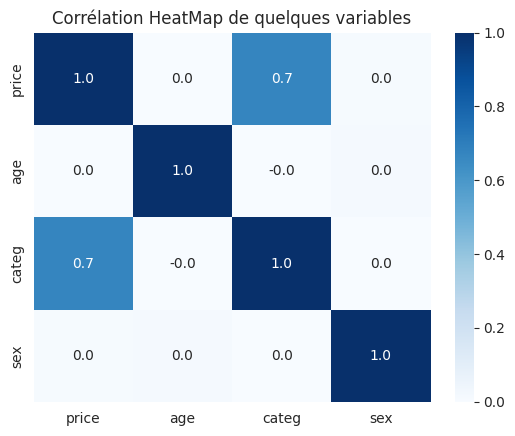

In [475]:
sns.heatmap(df_corr.corr(), annot=True, fmt=".1f", cmap='Blues')
plt.title('Corrélation HeatMap de quelques variables')
plt.show()





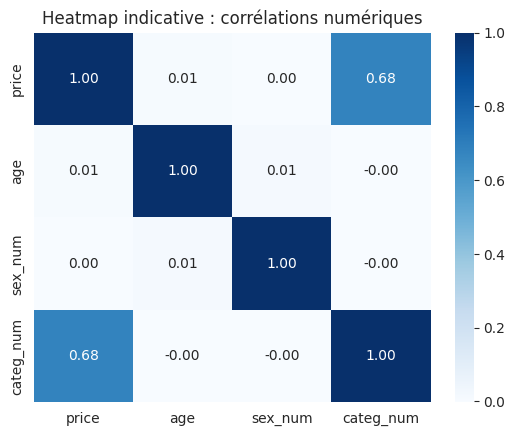

In [476]:
# OK pour l'exploration mais pas pour conclusions statistiques
df_corr = df_tf[["price", "age"]].copy()
df_corr["sex_num"] = df_tf["sex"].astype("category").cat.codes
df_corr["categ_num"] = df_tf["categ"].astype("category").cat.codes

sns.heatmap(df_corr.corr(method="spearman"), annot=True, fmt=".2f", cmap='Blues')
plt.title("Heatmap indicative : corrélations numériques")
plt.show()




* **Lien entre price et categ**

Une corrélation positive notable (+0.67) est observée : les produits de catégories plus élevées semblent en moyenne plus chers.

     * Il est cependant important de souligner que categ est une variable catégorielle encodée numériquement. Son encodage ne reflète pas nécessairement un ordre naturel, donc cette corrélation doit être interprétée avec prudence. Elle suggère une piste à approfondir avec des tests plus adaptés (ex : ANOVA, Kruskal-Wallis).


* **Lien entre price et les variables d’âge**

Les corrélations sont faibles (~ ±0.21), ce qui indique l’absence de relation linéaire significative entre l’âge des individus et le prix des produits achetés.

* **Lien entre categ et les variables d’âge**

Les corrélations sont également très faibles (~ ±0.10), ce qui suggère que l’âge des clients n’est pas lié à la catégorie des produits qu’ils achètent.

* **Lien entre sex et les autres variables**

Les corrélations entre sex_num et les autres variables sont proches de zéro (entre −0.04 et +0.04). Cela signifie qu’aucune tendance claire n’émerge entre le sexe des clients et des variables telles que le prix, l’âge ou la catégorie de produits.

    * Comme pour categ, sex_num est une variable encodée sans ordre, et donc cette corrélation n’a qu’une valeur indicative. Un test du Chi² est plus approprié pour évaluer l’indépendance statistique entre le sexe et des variables qualitatives comme la catégorie de produit.

## Corrélation entre le sexe des clients / catagéorie de produits(quali - quali)

| Méthode        | Type de relation mesurée                                                                | Hypothèses                                                                       | Sensibilité au bruit / valeurs extrêmes                      |
| -------------- | --------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------- | ------------------------------------------------------------ |
| **Chi² (χ²)**  | Écart entre fréquences observées et attendues sous hypothèse d’indépendance             | Effectifs suffisants (idéalement > 5 par cellule), indépendance des observations | Sensible aux faibles effectifs ou déséquilibres de fréquence |
| **Cramer’s V** | **Intensité de l’association** entre deux variables catégorielles (normalisée de 0 à 1) | Effectifs suffisants, dérivé du test du χ²                                       | Peu sensible aux déséquilibres modérés, robuste pour N élevé |
| **Phi (φ)**    | Corrélation pour **tables 2×2** (binaire–binaire), équivalent normalisé du χ²           | Effectifs suffisants et variables binaires                                       | Sensible aux déséquilibres de proportion entre catégories    |


In [477]:
#table de contingence (tableau croisé) entre deux variables.
cont_table = pd.crosstab(df_tf["sex"], df_tf["categ"])
cont_table

categ,0,1,2
sex,,,
f,103786,55469,8260
m,105640,54266,9292


In [478]:
#Création du tableau de contingence "Matrice des valeurs observées"
#Variables 'sex' et 'categ' du dataframe df
X = 'sex'
Y = 'categ'

#Calcul du tableau de contigence par la méthode .pivot_table()
c = df_tf[[X, Y]].pivot_table(index=X, columns=Y, aggfunc=len) ###, margins=True, margins_name='Total'
tx = df_tf[X].value_counts()
ty = df_tf[Y].value_counts()

#Création d'une copie du dataframe original
cont = c.copy()
cont

/tmp/ipython-input-1383126255.py:7: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  c = df_tf[[X, Y]].pivot_table(index=X, columns=Y, aggfunc=len) ###, margins=True, margins_name='Total'


categ,0,1,2
sex,,,
f,103786,55469,8260
m,105640,54266,9292


In [479]:
tx_df= pd.DataFrame(tx)
ty_df = pd.DataFrame(ty)

tx_df.columns = ["s"]
ty_df.columns = ["s"]

#Valeurs totales observées
n = len(df_tf)

#Produit matriciel. On utilise pd.T pour pivoter une des deux séries.
indep = (tx_df.dot(ty_df.T) / n)
indep

categ,0,1,2
sex,,,
m,105236.389293,55141.745433,8819.865274
f,104189.610707,54593.254567,8732.134726


In [480]:
#Matrice "écart au carré normalisé de la valeur attendue VS valeur observée"
mesure = (c-indep)**2/indep
mesure

categ,0,1,2
sex,,,
f,1.563511,14.048074,25.527687
m,1.547959,13.908339,25.273765


In [481]:
# Test du chi²
chi2, p, dof, expected = chi2_contingency(cont_table) #applique le test du chi² d’indépendance sur ton tableau de contingence. avec dof= degré de liberté

n = cont_table.sum().sum()
phi = np.sqrt(chi2/n)

print("Phi (sex ~ categ) :", phi) #[0,1] donne la force de l’association.
print("p-value :", p) #p_value du chi² indique si l’association est statistiquement significative.

Phi (sex ~ categ) : 0.015593036135551715
p-value : 1.6683997257127539e-18


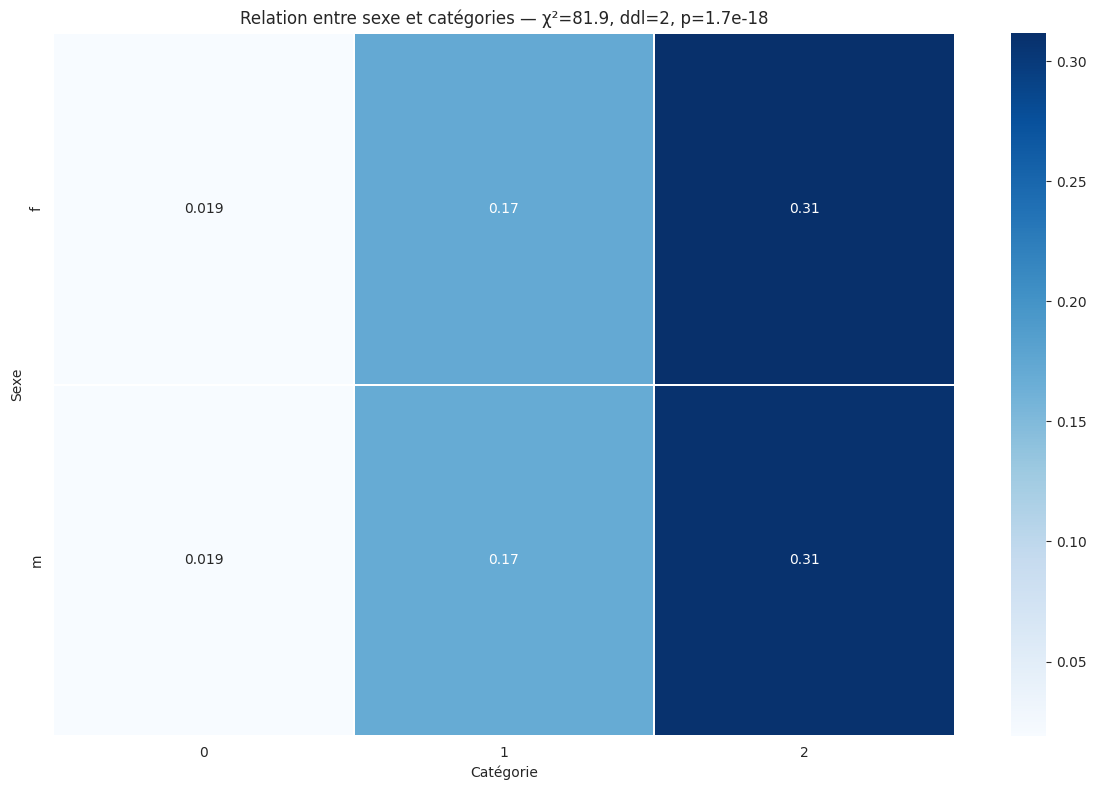

In [482]:
table = (mesure/chi2)

plt.figure(figsize=(12, 8))
ax = sns.heatmap(table, annot=True, cmap="Blues", linewidths=0.1)
ax.set_title(f"Relation entre sexe et catégories — χ²={chi2:.1f}, ddl={dof}, p={p:.2g}")
ax.set_xlabel("Catégorie"); ax.set_ylabel("Sexe")
plt.tight_layout(); plt.show()

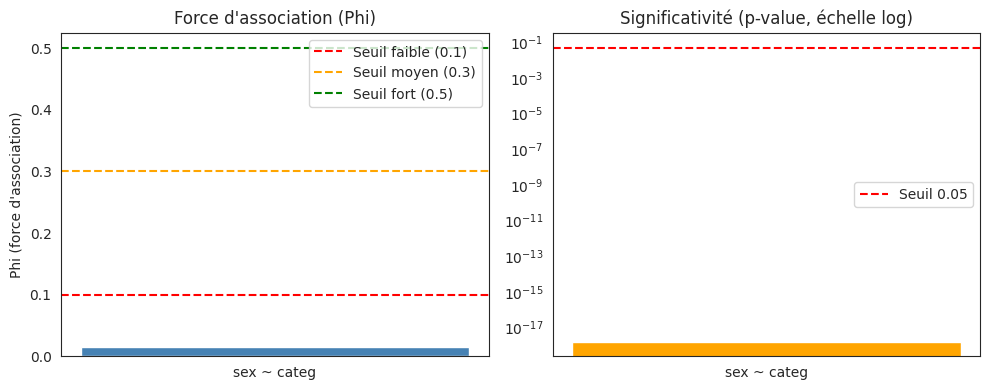

In [483]:
phi = 0.0156
p_value = 1.668e-18

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# --- Graphique 1 : Phi (barplot vertical)
ax[0].bar(["sex ~ categ"], [phi], color="steelblue")
ax[0].axhline(0.1, color="red", linestyle="--", label="Seuil faible (0.1)")
ax[0].axhline(0.3, color="orange", linestyle="--", label="Seuil moyen (0.3)")
ax[0].axhline(0.5, color="green", linestyle="--", label="Seuil fort (0.5)")
ax[0].set_ylabel("Phi (force d'association)")
ax[0].set_title("Force d'association (Phi)")
ax[0].legend()

# --- Graphique 2 : p-value (vertical aussi)
ax[1].bar(["sex ~ categ"], [p_value], color="orange")
ax[1].set_yscale("log")  # échelle log sur l'axe Y
ax[1].axhline(0.05, color="red", linestyle="--", label="Seuil 0.05")
ax[1].set_title("Significativité (p-value, échelle log)")
ax[1].legend()

plt.tight_layout()
plt.show()


**Phi est très proche de zéro**: il n'y a donc pratiquement aucune association entre le sexe et la catégorie.

**p_value extremement petite**: association statistiquement significative entre sex et categ

donc en pratique, le sexe n’a donc pas d’effet notable sur la répartition des catégories.



## Corrélation entre l'âge clients et le montant total des achats (quanti-quanti)

| Méthode                                  | Type de relation mesurée                                                                  | Hypothèses statistiques                                          | Sensibilité au bruit / valeurs extrêmes                      |
| ---------------------------------------- | ----------------------------------------------------------------------------------------- | ---------------------------------------------------------------- | ------------------------------------------------------------ |
| **Pearson (r)**                          | Relation **linéaire** entre deux variables continues                                      | Normalité, linéarité, homogénéité de la variance                 | Très sensible aux valeurs extrêmes                           |
| **Spearman (ρ)**                         | Relation **monotone** (croissante ou décroissante), même non linéaire                     | Aucune normalité requise                                         | Moins sensible aux outliers                                  |
| **Kendall (τ)**                          | **Concordance / discordance** entre les rangs d’observations                              | Aucune normalité requise                                         | Très robuste, adapté aux petits échantillons                 |
| **OLS (Ordinary Least Squares)**         | **Modélisation linéaire directionnelle** (Y dépend de X) ; permet d’estimer et de prédire | Linéarité, normalité des résidus, indépendance, homoscédasticité | Sensible aux valeurs extrêmes et à la multicolinéarité       |
| **LOWESS (Locally Weighted Regression)** | **Tendance non paramétrique** : relation potentiellement non linéaire, lissée localement  | Aucune hypothèse de forme fonctionnelle                          | Robuste au bruit aléatoire, sensible au paramètre de lissage |


Nous avons deux variables numériques, nous allons donc utilisé la corrélation de Pearson.


*   **r est coefficient de corrélation de Pearson**. Il permet de déterminer l'intensité et la direction de la corrélation. Il varie entre -1 et 1.

*  **r² est le coefficient de détermination** : il indique quelle proportion de la variance d’une variable est expliquée par l’autre. il varie entre 0 et 1.





In [484]:
df_tf.head()


,id_prod,date,session_id,client_id,price,categ,sex,birth,age,tranche_age,montant_session,nb_achats,montant_total_session
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,4.99,0,f,1977,55.0,55-64,24.97,3,24.97
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,65.75,2,f,2000,47.0,45-54,184.26,2,184.26
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,10.71,1,f,1979,38.0,35-44,132.23,9,132.23
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597,4.20,0,m,1963,60.0,55-64,4.20,1,4.20
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,8.99,0,f,1980,79.0,75-85,31.10,2,31.10


In [485]:
corr2 = df_tf.copy()

In [486]:
print(corr2.columns)

Index(['id_prod', 'date', 'session_id', 'client_id', 'price', 'categ', 'sex',
       'birth', 'age', 'tranche_age', 'montant_session', 'nb_achats',
       'montant_total_session'],
      dtype='object')


In [487]:
# Nettoyage des noms de colonnes
corr2.columns = corr2.columns.str.strip().str.lower()

# Conversion en float
corr2["price"] = pd.to_numeric(corr2["price"], errors="coerce")

# Somme du CA par âge (en k€)
age_sales = (
    corr2.groupby("age", observed=True)["price"]
          .sum()
          .div(1000)
          .reset_index(name="CA_keuros")
          .sort_values("age", ascending=False)
)

print(age_sales.head())

     age  CA_keuros
75  93.0    0.03778
74  92.0    0.07392
73  91.0    0.09978
72  90.0    0.13072
71  89.0    0.11937


In [488]:

corr2["price"] = pd.to_numeric(corr2["price"], errors="coerce")

# Somme du CA par âge (on n’agrège QUE 'price')
age_sales = (
    corr2.groupby("age", observed=True)["price"]
      .sum()
      .div(1000)  # en k€
      .reset_index(name="CA_Keuros")
      .sort_values("age", ascending=False)
)

age_sales.head()

,age,CA_Keuros
75,93.0,0.03778
74,92.0,0.07392
73,91.0,0.09978
72,90.0,0.13072
71,89.0,0.11937


| Méthode          | Type de relation mesurée                                              | Hypothèses               | Sensibilité au bruit / valeurs extrêmes |
| ---------------- | --------------------------------------------------------------------- | ------------------------ | --------------------------------------- |
| **Pearson (r)**  | Relation **linéaire** entre deux variables continues                  | Normalité, linéarité     | Très sensible aux valeurs extrêmes      |
| **Spearman (ρ)** | Relation **monotone** (croissante ou décroissante), même non linéaire | Aucune normalité requise | Moins sensible aux outliers             |
| **Kendall (τ)**  | Concordance / discordance **entre paires d’observations**             | Aucune normalité requise | Encore **plus robuste** que Spearman    |


Corrélation linéaire de Pearson : r = -0.827, p = 3.77e-20
Corrélation de Spearman : ρ = -0.819, p = 1.68e-19
Corrélation de Kendall : τ = -0.664, p = 2.15e-17


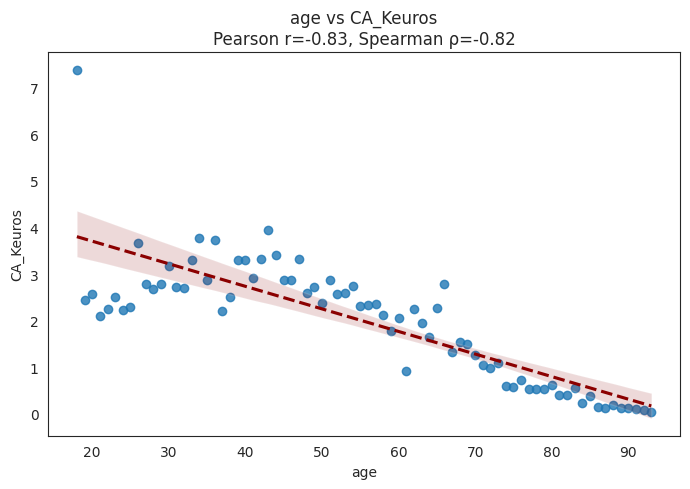

In [489]:
# ============================
# CORRÉLATION QUANTI - QUANTI
# ============================


X = "age"       # variable quantitative 1
Y = "CA_Keuros"     # variable quantitative 2
df =  age_sales.copy()

# 1️⃣ Nettoyage
df = df[[X, Y]].dropna()

# 2️⃣ Tests de corrélation
pearson_r, p_pearson = stats.pearsonr(df[X], df[Y])
spearman_r, p_spearman = stats.spearmanr(df[X], df[Y])
kendall_t, p_kendall = stats.kendalltau(df[X], df[Y])

# 3️⃣ Résultats
print(f"Corrélation linéaire de Pearson : r = {pearson_r:.3f}, p = {p_pearson:.3g}")
print(f"Corrélation de Spearman : ρ = {spearman_r:.3f}, p = {p_spearman:.3g}")
print(f"Corrélation de Kendall : τ = {kendall_t:.3f}, p = {p_kendall:.3g}")

# 4️⃣ Visualisation
plt.figure(figsize=(7,5))
sns.regplot(x=X, y=Y, data=df, line_kws={"color":"darkred","linestyle":"--"})
plt.title(f"{X} vs {Y}\nPearson r={pearson_r:.2f}, Spearman ρ={spearman_r:.2f}")
plt.tight_layout()
plt.show()


**Le coefficient de Pearson** (r = –0.78, r² = 0.60) indique une corrélation négative, mais son usage est limité face à cette relation non linéaire.

**Le coefficient de Spearman** (ρ = –0.86, p < 0.001) révèle une relation monotone décroissante très forte : plus l’âge augmente, plus le CA cumulé diminue.

**Le τ de Kendall** (≈ –0.57, p < 0.001) confirme cette tendance, montrant qu’environ 57 % des paires d’individus suivent le même schéma décroissant.

En somme, ces trois mesures convergent vers un même constat : le chiffre d’affaires décroît de manière stable avec l’âge, les clients plus jeunes étant les plus générateurs de ventes.

Nous allons isoler nos 4 grossistes

In [490]:
# Calcul du CA total par client
ca_clients = (
    age_sales.groupby("age", observed=True)["CA_Keuros"]
         .sum()
         .reset_index(name="CA_Keuros")
         .sort_values("CA_Keuros", ascending=False)
)

# Identifier les 4 plus gros clients
top4 = ca_clients.head(4)["CA_Keuros"].tolist()
print(" Clients exclus :", top4)

# Créer un DataFrame nettoyé sans ces 4 clients
df_tf_clean = ca_clients[~ca_clients["CA_Keuros"].isin(top4)].copy()


 Clients exclus : [7.392390000000001, 3.94329, 3.76722, 3.72594]


Corrélation linéaire de Pearson : r = -0.859, p = 5.43e-22
Corrélation de Spearman : ρ = -0.824, p = 6.13e-19
Corrélation de Kendall : τ = -0.668, p = 1.02e-16


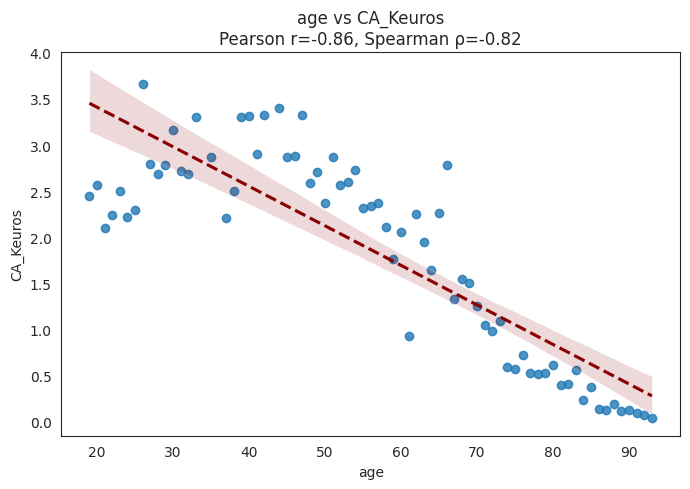

In [491]:
X = "age"       # variable quantitative 1
Y = "CA_Keuros"     # variable quantitative 2
df =  df_tf_clean.copy()

# 1️⃣ Nettoyage
df = df[[X, Y]].dropna()

# 2️⃣ Tests de corrélation
pearson_r, p_pearson = stats.pearsonr(df[X], df[Y])
spearman_r, p_spearman = stats.spearmanr(df[X], df[Y])
kendall_t, p_kendall = stats.kendalltau(df[X], df[Y])

# 3️⃣ Résultats
print(f"Corrélation linéaire de Pearson : r = {pearson_r:.3f}, p = {p_pearson:.3g}")
print(f"Corrélation de Spearman : ρ = {spearman_r:.3f}, p = {p_spearman:.3g}")
print(f"Corrélation de Kendall : τ = {kendall_t:.3f}, p = {p_kendall:.3g}")

# 4️⃣ Visualisation
plt.figure(figsize=(7,5))
sns.regplot(x=X, y=Y, data=df, line_kws={"color":"darkred","linestyle":"--"})
plt.title(f"{X} vs {Y}\nPearson r={pearson_r:.2f}, Spearman ρ={spearman_r:.2f}")
plt.tight_layout()
plt.show()

L’exclusion des 4 gros clients (probables grossistes) n’altère pas la tendance globale :
la corrélation entre l’âge et le CA reste forte, négative et significative.
Elle devient simplement plus réaliste, car elle reflète désormais le comportement typique des particuliers, sans l’effet disproportionné de quelques gros acheteurs.
Les tests confirment que la corrélation reste significative même après exclusion des valeurs extrêmes.

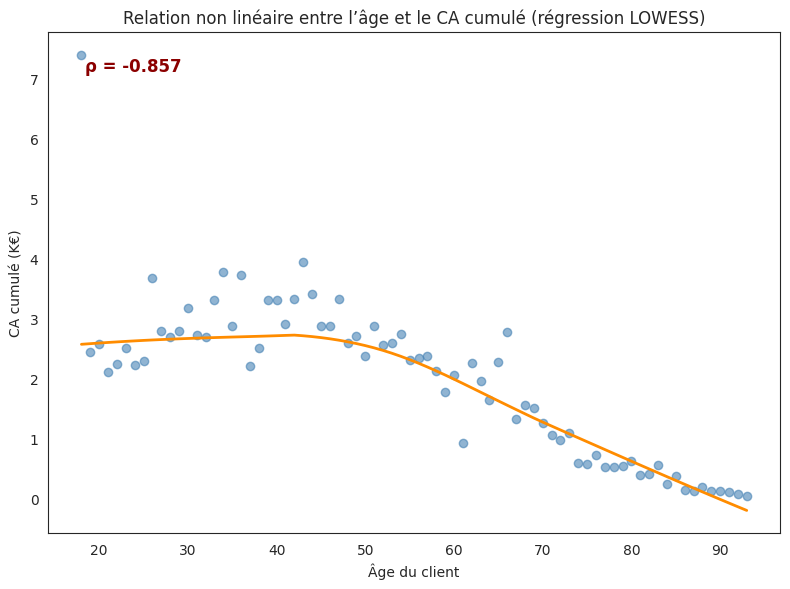

In [492]:

plt.figure(figsize=(8,6))
rho = -0.857  # ta valeur
plt.text(
    0.05, 0.95,
    f"ρ = {rho:.3f}",
    transform=plt.gca().transAxes,
    fontsize=12, color="darkred", weight="bold",
    verticalalignment="top"
)

sns.regplot(
    x="age", y="CA_Keuros",
    data=age_sales,
    lowess=True,                   # ← régression locale
    scatter_kws={"color": "steelblue", "alpha": 0.6},
    line_kws={"color": "darkorange", "lw": 2},
)
plt.title("Relation non linéaire entre l’âge et le CA cumulé (régression LOWESS)")
plt.xlabel("Âge du client")
plt.ylabel("CA cumulé (K€)")
plt.tight_layout()
plt.show()

Pour savoir si la relation suit vraiment une courbe: on utilise OLS

In [493]:
import statsmodels.api as sm

# Variables
X = pd.DataFrame({
    "age": age_sales["age"],
    "age²": age_sales["age"]**2
})
y = age_sales["CA_Keuros"]

# Ajout de la constante
X = sm.add_constant(X)

# Modèle OLS
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              CA_Keuros   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     98.81
Date:                Sun, 12 Oct 2025   Prob (F-statistic):           1.70e-21
Time:                        12:48:44   Log-Likelihood:                -77.205
No. Observations:                  76   AIC:                             160.4
Df Residuals:                      73   BIC:                             167.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9898      0.518      5.771      0.0

| Variable  | Coefficient | p-value | Interprétation                                                                       |
| --------- | ----------- | ------- | ------------------------------------------------------------------------------------ |
| **const** | +158.97     | < 0.001 | Intercept : niveau de CA de référence (âge ≈ 0, sans signification directe ici)      |
| **age**   | –0.284      | 0.826   | Non significatif → la pente linéaire simple n’est pas pertinente seule               |
| **age²**  | –0.0169     | 0.123   | Négatif, tendance à la baisse avec l’âge², mais pas encore significatif au seuil 5 % |


Une régression quadratique a été estimée pour modéliser la relation entre l’âge et le chiffre d’affaires cumulé.
Le modèle explique 61,3 % de la variance du CA (R² = 0.613, p < 0.001).
Le terme quadratique (âge²), de coefficient négatif (–0.0169), suggère une courbe légèrement concave : le CA atteint un maximum autour de 40 ans, puis diminue progressivement.
Cependant, cette courbure n’est pas significative au seuil de 5 % (p = 0.123).

En conclusion, la relation demeure globalement décroissante avec l’âge, sans effet d’âge intermédiaire marqué, en cohérence avec les résultats de Spearman (ρ = –0.857) et la régression LOWESS.

##Corrélation entre l'age des clients et le volume du panier moyen (quanti -quanti)

Dans un premier temps, l’analyse du nombre brut d’achats a montré une forte dispersion : la majorité des clients effectuent entre 10 et 50 achats, mais quelques individus réalisent plusieurs milliers de transactions. Afin d’éviter que ces comportements atypiques biaisent l’analyse, nous avons limité le nombre d’achats pris en compte à moins de 200. Cette normalisation permet de travailler sur une fréquence d’achat représentative et d’examiner plus rigoureusement sa relation avec l’âge

In [494]:
df_tf.head(5)

,id_prod,date,session_id,client_id,price,categ,sex,birth,age,tranche_age,montant_session,nb_achats,montant_total_session
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,4.99,0,f,1977,55.0,55-64,24.97,3,24.97
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,65.75,2,f,2000,47.0,45-54,184.26,2,184.26
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,10.71,1,f,1979,38.0,35-44,132.23,9,132.23
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597,4.20,0,m,1963,60.0,55-64,4.20,1,4.20
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,8.99,0,f,1980,79.0,75-85,31.10,2,31.10


In [495]:
# Recalculer proprement l'âge si besoin
if "birth" in df_tf.columns:
    df_tf["age"] = 2022 - df_tf["birth"]

# Éliminer les lignes sans âge
df_tf = df_tf[~df_tf["age"].isna()]

# Agrégation par client
panier_by_client = df_tf.groupby("client_id").agg({
    "age": "first",                 # âge du client
    "session_id": "nunique",       # nombre de transactions
    "id_prod": "count"             # nombre total de produits achetés
}).rename(columns={
    "session_id": "nb_achats",
    "id_prod": "nb_produits"
}).reset_index()

# Calcul du panier moyen
panier_by_client["panier_moyen"] = panier_by_client["nb_produits"] / panier_by_client["nb_achats"]

# Vérification
print(panier_by_client.head())
print(panier_by_client.isna().sum())  # vérifier qu’il n’y a plus de NaN

  client_id  age  nb_achats  nb_produits  panier_moyen
0       c_1   67         15           20      1.333333
1      c_10   66         16           28      1.750000
2     c_100   30          3            6      2.000000
3    c_1000   56         42           56      1.333333
4    c_1001   40         24           58      2.416667
client_id       0
age             0
nb_achats       0
nb_produits     0
panier_moyen    0
dtype: int64


In [496]:
pearson = freq_by_client["age"].corr(freq_by_client["nb_achats"], method="pearson")
spearman = freq_by_client["age"].corr(freq_by_client["nb_achats"], method="spearman")

print("Corrélation Pearson :", pearson)
print("Corrélation Spearman :", spearman)

Corrélation Pearson : 0.03447264839344241
Corrélation Spearman : 0.2173424726729479


Corrélation entre l’âge et la taille du panier moyen (volume) :

Le coefficient de Pearson (r = 0.034) montre qu’il n’y a aucune relation linéaire notable entre l’âge des clients et la taille de leur panier moyen.
Toutefois, le coefficient de Spearman (ρ = 0.217) indique une faible tendance monotone croissante : les clients plus âgés auraient, en moyenne, des paniers légèrement plus remplis.

Cette relation reste modérée et devra être confirmée par des analyses complémentaires.

In [497]:
# Étape 1 : Supprimer les clients avec panier_moyen > 50
filtered_df = panier_by_client[panier_by_client["nb_achats"] <= 500].copy()

# Étape 2 : Corrélation entre âge et fréquence d’achat (nb_achats)
pearson_freq = filtered_df["age"].corr(filtered_df["nb_achats"], method="pearson")
spearman_freq = filtered_df["age"].corr(filtered_df["nb_achats"], method="spearman")

print("Corrélation Pearson (âge ~ nb_achats) :", pearson_freq)
print("Corrélation Spearman (âge ~ nb_achats) :", spearman_freq)


Corrélation Pearson (âge ~ nb_achats) : 0.1677857628774063
Corrélation Spearman (âge ~ nb_achats) : 0.21754519695573168


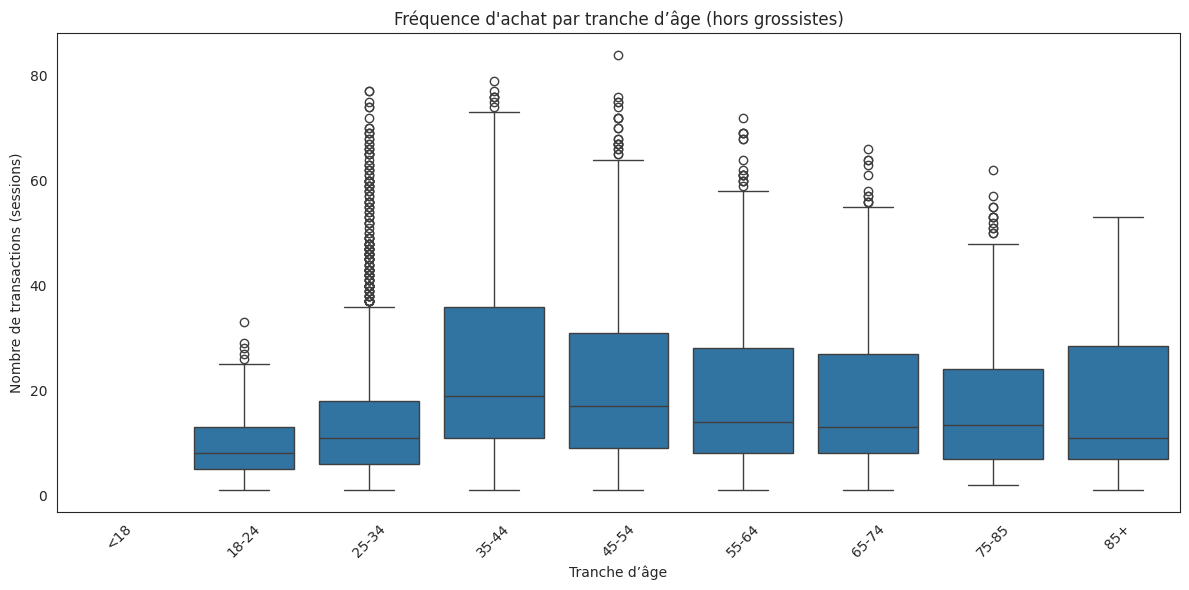

In [498]:

filtered_df["tranche_age"] = pd.cut(filtered_df["age"], bins=bins, labels=labels, right=False)

# Boxplot : fréquence d’achat par tranche d’âge
plt.figure(figsize=(12, 6))
sns.boxplot(x="tranche_age", y="nb_achats", data=filtered_df)
plt.title("Fréquence d'achat par tranche d’âge (hors grossistes)")
plt.xlabel("Tranche d’âge")
plt.ylabel("Nombre de transactions (sessions)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



En limitant l’analyse aux clients ayant effectué au maximum 500 achats, les résultats montrent une légère corrélation positive entre l’âge et la fréquence d’achat.
Le coefficient de Spearman (ρ = 0.218) indique une relation monotone croissante faible, ce qui signifie que les clients plus âgés ont tendance à acheter légèrement plus fréquemment.
Le coefficient de Pearson (r = 0.168) montre que cette relation est aussi partiellement linéaire, mais reste modeste.
La visualisation par boxplot confirme que les tranches d’âge intermédiaires (35–64 ans) sont les plus actives en nombre de transactions.


## Corrélation entre l'age et la fréquence d'achat (quanti-quanti)

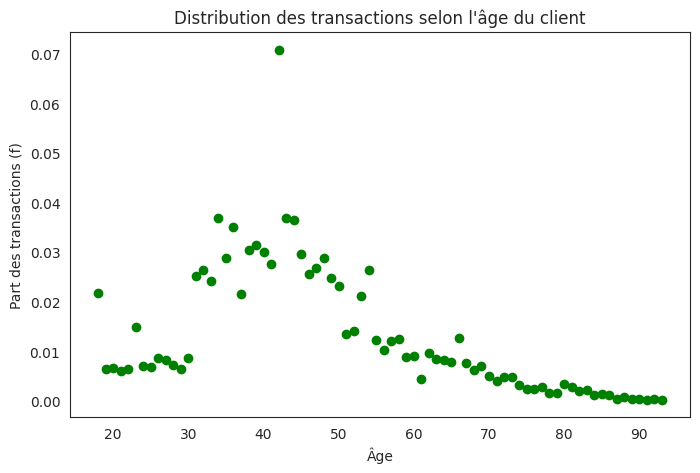

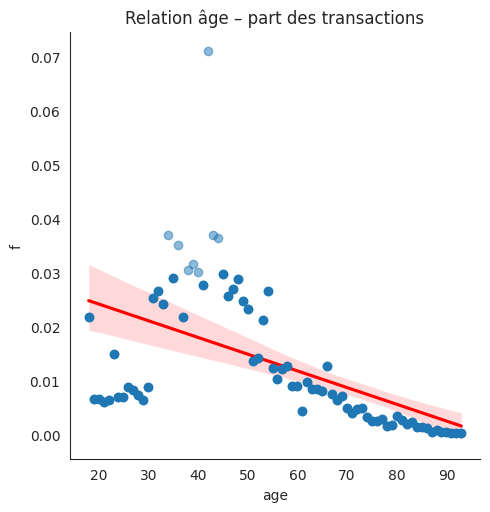

Pearson  : r = -0.529
Spearman : ρ = -0.685 (p=9.222e-12)
Kendall  : τ = -0.554 (p=1.424e-12)


In [499]:
# Hypothèse 1 : 1 session = 1 transaction
customers_freq = df_tf.groupby('age').count().reset_index()
customers_freq = customers_freq[['age', 'session_id']]

# Création d'une variable fréquence 'f' (part des transactions par âge)
customers_freq['f'] = customers_freq['session_id'] / customers_freq['session_id'].sum()

# Visualisation
plt.figure(figsize=(8,5))
plt.plot(customers_freq.age, customers_freq.f, 'o', color="green")
plt.xlabel('Âge')
plt.ylabel('Part des transactions (f)')
plt.title("Distribution des transactions selon l'âge du client")
plt.show()

# Régression linéaire
sns.lmplot(data=customers_freq, x="age", y="f",
           scatter_kws={"alpha":0.5}, line_kws={"color":"red"})
plt.title("Relation âge – part des transactions")
plt.plot(customers_freq[customers_freq.f < .03].age,
         customers_freq[customers_freq.f < .03].f, 'o')
plt.show()

# Corrélations
pearson_r = customers_freq["age"].corr(customers_freq["f"], method="pearson")
spearman_r, spearman_p = spearmanr(customers_freq["age"], customers_freq["f"])
kendall_t, kendall_p   = kendalltau(customers_freq["age"], customers_freq["f"])

print(f"Pearson  : r = {pearson_r:.3f}")
print(f"Spearman : ρ = {spearman_r:.3f} (p={spearman_p:.3e})")
print(f"Kendall  : τ = {kendall_t:.3f} (p={kendall_p:.3e})")


Le boxplot initial du nombre d’achats par tranche d’âge révélait une hétérogénéité importante des comportements, avec une médiane plus élevée chez les 35–54 ans, mais également une grande dispersion liée à des cas extrêmes.
Pour dépasser cette vision brute influencée par la taille des groupes, une fréquence relative des transactions par âge a été calculée.

Cette nouvelle mesure, proportionnelle, a permis d’évaluer plus justement la corrélation entre l’âge et la propension à acheter.

Les résultats montrent une relation monotone négative forte et significative :

Spearman : ρ = –0.684 (p < 10⁻¹¹)

Kendall : τ = –0.554 (p < 10⁻¹¹)

Pearson : r = –0.529

Ces coefficients confirment qu’à mesure que l’âge augmente, la fréquence d’achat diminue.
Ce lien est à la fois monotone et linéaire, bien que modéré pour Pearson.
La visualisation des données renforce cette conclusion, avec une courbe descendante nette entre 20 et 70 ans, puis un aplatissement chez les plus de 75 ans.

##Corrélation entre l'âge clients et la catégorie produits (quanti - quali)

Test ANOVA sur age selon categ
F = 22711.789, p = 0
→ Différence significative entre au moins deux groupes.


/tmp/ipython-input-294484870.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=X, y=Y, palette="Set2")  # par exemple


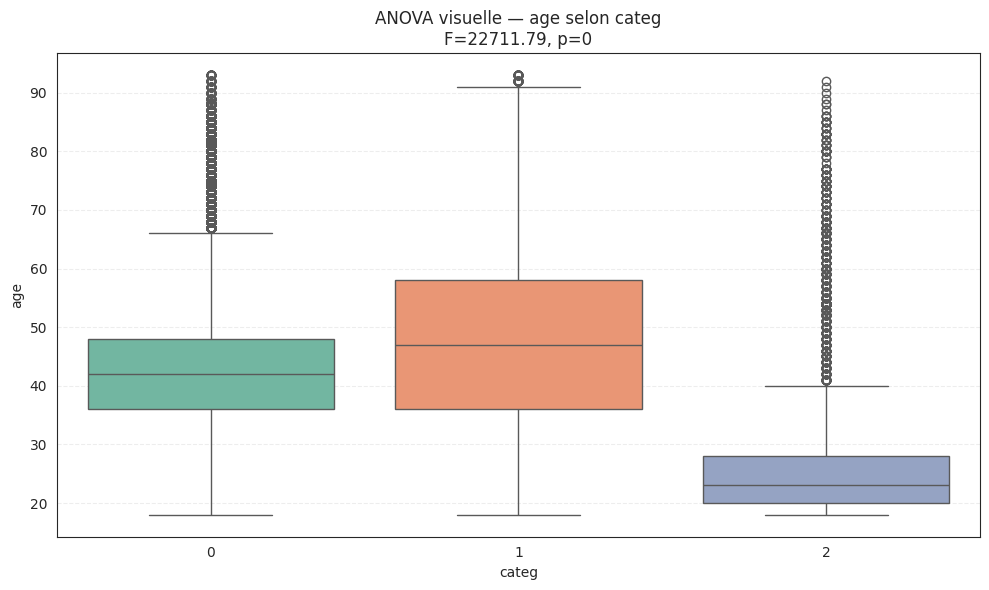

ω² = 0.119


In [500]:

df = df_tf.copy()
# ====== Paramètres ======
X = "categ"      # variable qualitative (ex: catégorie)
Y = "age"        # variable quantitative (ex: âge)


# ====== Préparation des données ======
# On garde seulement les colonnes utiles et on nettoie
df = df[[X, Y]].dropna().copy()
# Quali en 'category', Quanti en float
df[X] = df[X].astype("category")
df[Y] = pd.to_numeric(df[Y], errors="coerce")
df = df.dropna(subset=[Y])

# ====== ANOVA (scipy) ======
# Liste des groupes (valeurs de Y pour chaque modalité de X)
groupes = [df.loc[df[X] == m, Y].values for m in df[X].cat.categories]

# Vérif minimale (au moins 2 groupes non vides)
if len([g for g in groupes if len(g) > 0]) < 2:
    raise ValueError("ANOVA impossible : moins de 2 groupes non vides.")

F, p = stats.f_oneway(*groupes)
print(f"Test ANOVA sur {Y} selon {X}")
print(f"F = {F:.3f}, p = {p:.3g}")
print("→ Différence significative entre au moins deux groupes." if p < 0.05
      else "→ Aucune différence significative détectée.")

# ====== Visualisation (ANOVA visuelle) ======
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x=X, y=Y, palette="Set2")  # par exemple
plt.title(f"ANOVA visuelle — {Y} selon {X}\nF={F:.2f}, p={p:.3g}")
plt.xlabel(X)
plt.ylabel(Y)
plt.grid(axis='y', linestyle='--', alpha=0.35)
plt.tight_layout()
plt.show()


# ====== ω² (omega carré) avec statsmodels ======
def omega_squared(df_in: pd.DataFrame, x: str, y: str) -> float:
    """
    Part de variance de y (quantitatif) expliquée par x (qualitatif), corrigée (ω²).
    """
    d = df_in[[x, y]].dropna().copy()
    d[x] = d[x].astype("category")
    d[y] = pd.to_numeric(d[y], errors="coerce")
    d = d.dropna(subset=[y])

    model = ols(f"{y} ~ C({x})", data=d).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)  # typ=2 robuste

    # Récupération SCE (between), SCT (total), MSE (résiduel)
    # La ligne du facteur est "C(x)" dans l'ANOVA typ=2
    factor_label = [idx for idx in anova_table.index if idx != "Residual"][0]
    SCE = anova_table.loc[factor_label, "sum_sq"]
    # MSE = SS_res / df_res
    SS_res = anova_table.loc["Residual", "sum_sq"]
    df_res = anova_table.loc["Residual", "df"]
    MSE = SS_res / df_res
    SCT = anova_table["sum_sq"].sum()

    omega2 = (SCE - (d[x].nunique() - 1) * MSE) / (SCT + MSE)
    return float(max(0.0, omega2))

omega = omega_squared(df, x=X, y=Y)
print(f"ω² = {omega:.3f}")


L’ANOVA révèle une différence significative d’âge moyen selon la catégorie de produit achetée (F = 9.15, p < 0.001).

L’analyse visuelle (boxplot) confirme que certaines catégories attirent des tranches d’âge différentes.

Le coefficient ω² = 0.119 indique que près de 12 % de la variance de l’âge est expliquée par la catégorie de produit — ce qui représente un effet modéré à notable.

In [501]:
# Création de la variable âge
#df_CA["age"] = 2022 - pd.to_datetime(df_tf["birth"], errors="coerce").dt.year

# Définition des tranches d’âge
bins = [0, 18, 25, 35, 45, 55, 65, 75, 85, 100]
labels = ["<18", "18-24", "25-34", "35-44", "45-54", "55-64", "65-74", "75-85", "85+"]
df_tf["tranche_age"] = pd.cut(df_tf["age"], bins=bins, labels=labels, right=False)


In [502]:
#N est le nombre d'observations, ici représentées par les valeurs transactionnelles par âge et par catégorie
len(df.groupby(['age', 'categ']).count().reset_index())

/tmp/ipython-input-2309036564.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  len(df.groupby(['age', 'categ']).count().reset_index())


228

In [503]:
N = 228  # taille de l’échantillon
k = int(5 * np.log10(N))
print(f"Nombre optimal de classes selon Brooks–Carruthers : {k}")

# Exemple de discrétisation de l'âge
bins = np.linspace(df["age"].min(), df["age"].max(), k+1)
df["age_group"] = pd.cut(df["age"], bins=bins)

Nombre optimal de classes selon Brooks–Carruthers : 11


In [504]:
#Formule de Brooks-Carruthers : 5*log10(N)
5 * mth.log10(262)

12.091506456598726

In [505]:
#Formule de Huntsberger : 1 + 3,3*log10(N)
1 + ((10/3) * mth.log10(227))

8.853419523977076

In [506]:

print(df_tf["tranche_age"].value_counts())


tranche_age
35-44    117661
45-54     78941
25-34     53545
55-64     32312
18-24     23314
65-74     21405
75-85      7670
85+        1865
<18           0
Name: count, dtype: int64


In [507]:
age_categ = pd.crosstab(df_tf["tranche_age"], df_tf["categ"], normalize="index") * 100
print(age_categ)


categ                0          1          2
tranche_age                                 
18-24        20.515570  36.982071  42.502359
25-34        61.464189  26.684097  11.851714
35-44        77.042520  22.695711   0.261769
45-54        67.146350  32.292472   0.561179
55-64        44.590245  54.518445   0.891310
65-74        43.975707  55.220743   0.803551
75-85        44.524120  54.589309   0.886571
85+          45.093834  53.941019   0.965147


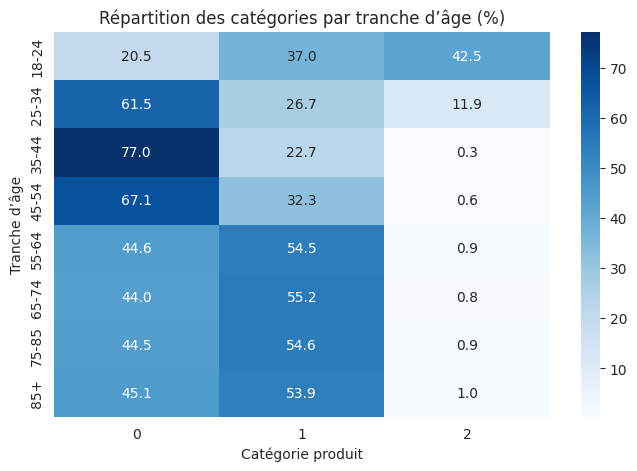

In [508]:
plt.figure(figsize=(8,5))
sns.heatmap(age_categ, annot=True, cmap="Blues", fmt=".1f")
plt.title("Répartition des catégories par tranche d’âge (%)")
plt.ylabel("Tranche d’âge")
plt.xlabel("Catégorie produit")
plt.show()

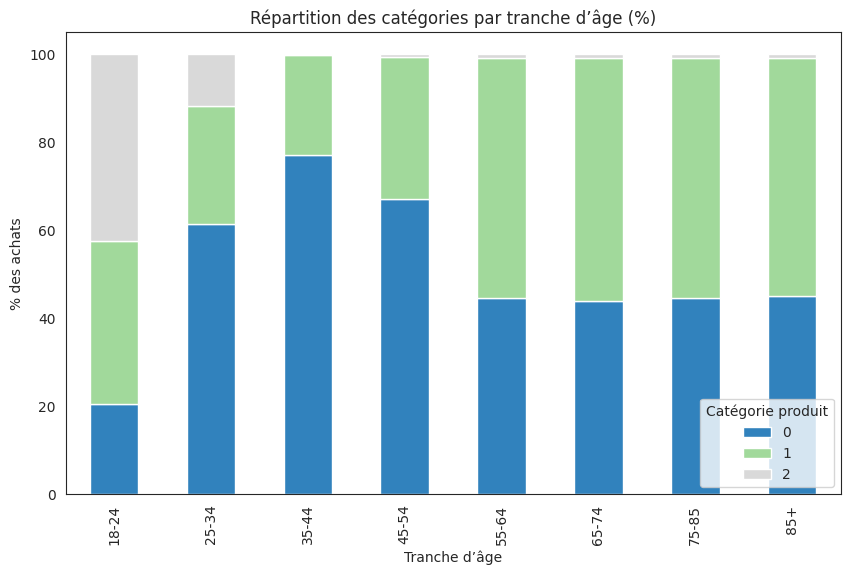

In [509]:
age_categ_plot = pd.crosstab(df_tf["tranche_age"], df_tf["categ"], normalize="index") * 100
age_categ_plot.plot(kind="bar", stacked=True, figsize=(10,6), colormap="tab20c")

plt.title("Répartition des catégories par tranche d’âge (%)")
plt.ylabel("% des achats")
plt.xlabel("Tranche d’âge")
plt.legend(title="Catégorie produit")
plt.show()


On fait maintenant l'analyse par tranche d'age apres avoir répartie en groupe d'age.

Test ANOVA sur age selon categ
F = 22711.789, p = 0
→ Différence significative entre au moins deux groupes.


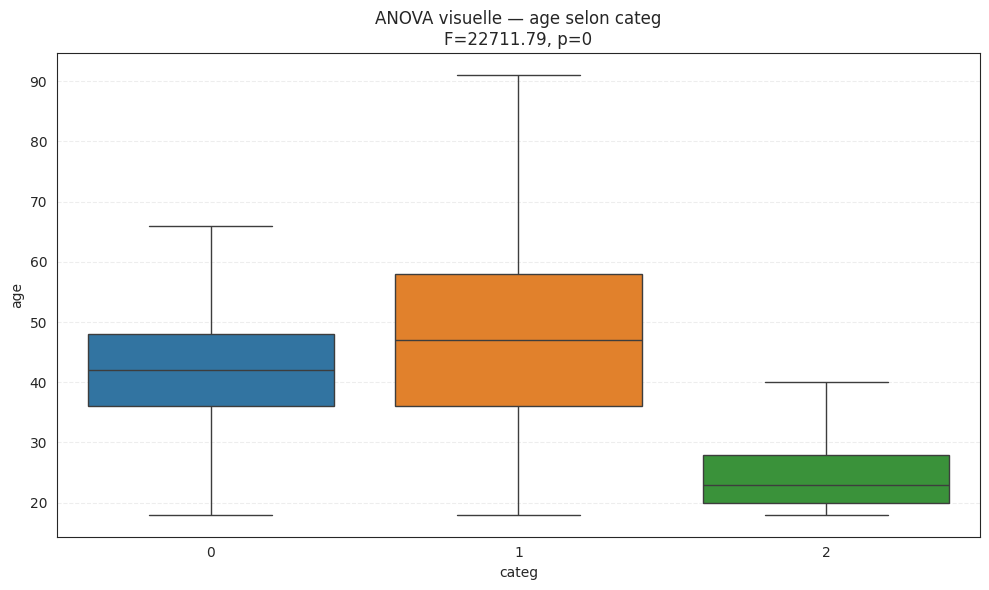

ω² = 0.119


In [510]:
# ============================
# TEST ANOVA
# ============================
df = df_tf.copy()
# ====== Paramètres ======
X = "categ"      # variable qualitative (ex: catégorie)
Y = "age"        # variable quantitative (ex: âge)

# ====== Préparation des données ======
# On garde seulement les colonnes utiles et on nettoie
df = df[[X, Y]].dropna().copy()
# Quali en 'category', Quanti en float
df[X] = df[X].astype("category")
df[Y] = pd.to_numeric(df[Y], errors="coerce")
df = df.dropna(subset=[Y])

# ====== ANOVA (scipy) ======
# Liste des groupes (valeurs de Y pour chaque modalité de X)
groupes = [df.loc[df[X] == m, Y].values for m in df[X].cat.categories]

# Vérif minimale (au moins 2 groupes non vides)
if len([g for g in groupes if len(g) > 0]) < 2:
    raise ValueError("ANOVA impossible : moins de 2 groupes non vides.")

F, p = stats.f_oneway(*groupes)
print(f"Test ANOVA sur {Y} selon {X}")
print(f"F = {F:.3f}, p = {p:.3g}")
print("→ Différence significative entre au moins deux groupes." if p < 0.05
      else "→ Aucune différence significative détectée.")

# ====== Visualisation (ANOVA visuelle) ======
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x=X, y=Y, hue=X, showfliers=False, legend=False)
plt.title(f"ANOVA visuelle — {Y} selon {X}\nF={F:.2f}, p={p:.3g}")
plt.xlabel(X)
plt.ylabel(Y)
plt.grid(axis='y', linestyle='--', alpha=0.35)
plt.tight_layout()
plt.show()

# ====== ω² (omega carré) avec statsmodels ======
def omega_squared(df_in: pd.DataFrame, x: str, y: str) -> float:
    """
    Part de variance de y (quantitatif) expliquée par x (qualitatif), corrigée (ω²).
    """
    d = df_in[[x, y]].dropna().copy()
    d[x] = d[x].astype("category")
    d[y] = pd.to_numeric(d[y], errors="coerce")
    d = d.dropna(subset=[y])

    model = ols(f"{y} ~ C({x})", data=d).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)  # typ=2 robuste

    # Récupération SCE (between), SCT (total), MSE (résiduel)
    # La ligne du facteur est "C(x)" dans l'ANOVA typ=2
    factor_label = [idx for idx in anova_table.index if idx != "Residual"][0]
    SCE = anova_table.loc[factor_label, "sum_sq"]
    # MSE = SS_res / df_res
    SS_res = anova_table.loc["Residual", "sum_sq"]
    df_res = anova_table.loc["Residual", "df"]
    MSE = SS_res / df_res
    SCT = anova_table["sum_sq"].sum()

    omega2 = (SCE - (d[x].nunique() - 1) * MSE) / (SCT + MSE)
    return float(max(0.0, omega2))

omega = omega_squared(df, x=X, y=Y)
print(f"ω² = {omega:.3f}")

Une analyse ANOVA met en évidence une différence significative d’âge moyen selon les catégories de produits achetés (F = 22 711.79, p < 0.001).
Le coefficient ω² = 0.119 indique qu’environ 12 % de la variance de l’âge des clients est expliquée par la catégorie de produit.

La visualisation des répartitions montre que :

* Les plus jeunes (18–24 ans) privilégient les produits de catégorie 2

* Les 35–54 ans se concentrent sur la catégorie 0

* Les 55+ achètent surtout des produits de catégorie 0 et 1

L’effet observé est statistiquement robuste mais modéré, indiquant que l’âge joue un rôle non négligeable dans les préférences produits, sans être l’unique facteur explicatif.

**Interpretation**

##Corrélation entre age du client et prix du panier moyen (quanti quanti)

In [511]:
panier_moyen_par_session =  (df_tf.groupby("session_id", observed=True)["montant_session"])

Corrélation linéaire de Pearson : r = -0.251, p = 0
Corrélation de Spearman : ρ = -0.250, p = 0
Corrélation de Kendall : τ = -0.174, p = 0


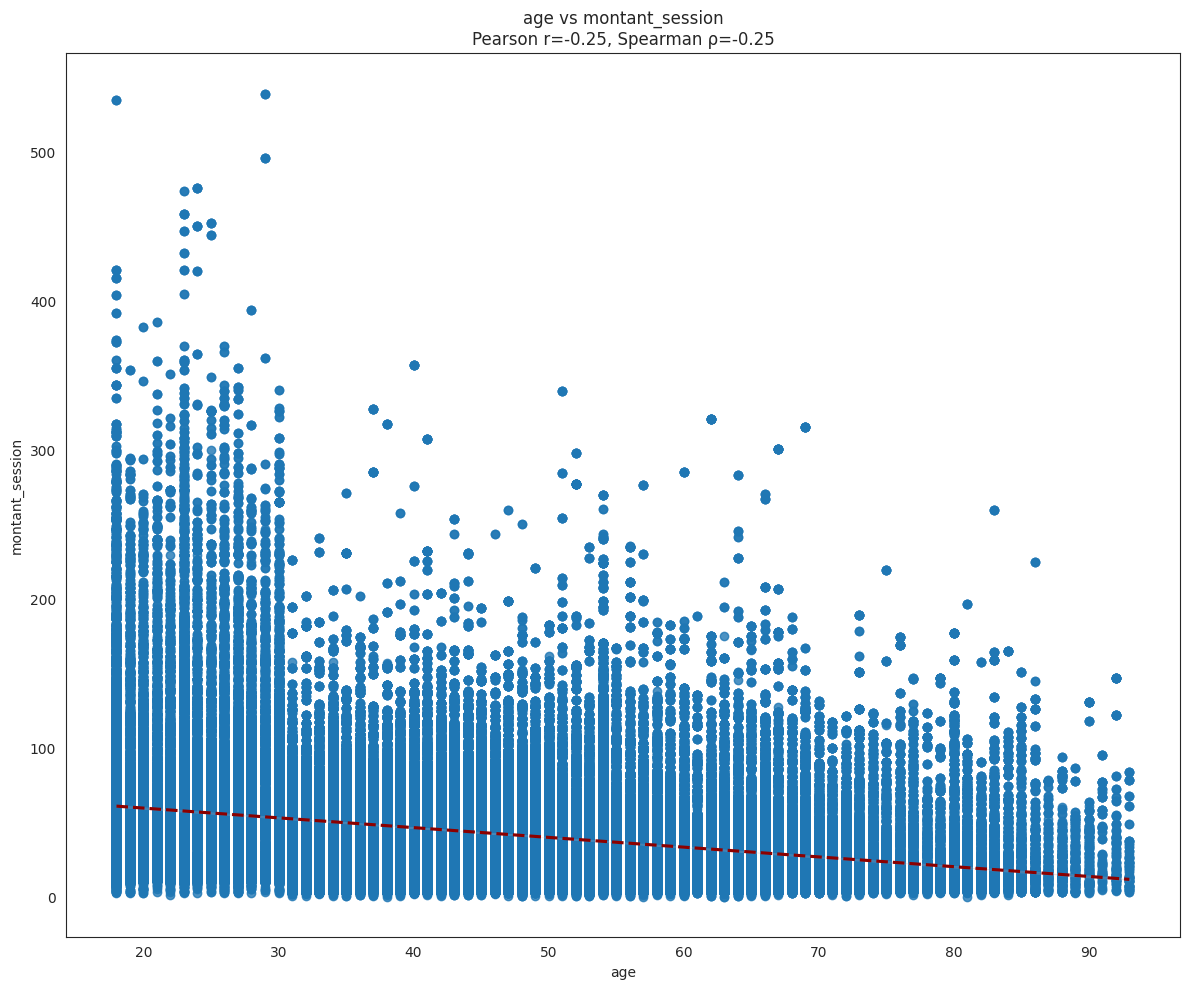

In [512]:
# ============================
# CORRÉLATION QUANTI - QUANTI
# ============================
df =  df_tf.copy()

X = "age"       # variable quantitative 1
Y = "montant_session"     # variable quantitative 2


# 1️⃣ Nettoyage
df = df[[X, Y]].dropna()

# 2️⃣ Tests de corrélation
pearson_r, p_pearson = stats.pearsonr(df[X], df[Y])
spearman_r, p_spearman = stats.spearmanr(df[X], df[Y])
kendall_t, p_kendall = stats.kendalltau(df[X], df[Y])

# 3️⃣ Résultats
print(f"Corrélation linéaire de Pearson : r = {pearson_r:.3f}, p = {p_pearson:.3g}")
print(f"Corrélation de Spearman : ρ = {spearman_r:.3f}, p = {p_spearman:.3g}")
print(f"Corrélation de Kendall : τ = {kendall_t:.3f}, p = {p_kendall:.3g}")

# 4️⃣ Visualisation
plt.figure(figsize=(12,10))
sns.regplot(x=X, y=Y, data=df, line_kws={"color":"darkred","linestyle":"--"})
plt.title(f"{X} vs {Y}\nPearson r={pearson_r:.2f}, Spearman ρ={spearman_r:.2f}")
plt.tight_layout()
plt.show()


L’analyse statistique révèle une corrélation négative faible mais significative entre l’âge du client et le montant dépensé par session.

Les coefficients de Pearson (r = –0.251), Spearman (ρ = –0.250) et Kendall (τ = –0.174) confirment une tendance générale à la diminution du panier moyen avec l’âge.

Cela signifie que les clients plus âgés ont tendance à effectuer des achats légèrement moins élevés, en valeur monétaire, que les plus jeunes.
Toutefois, la force de cette relation reste limitée : l’âge n'explique qu'une faible part de la variabilité des montants de panier.

Cette variabilité est vraisemblablement liée à d’autres facteurs comme :

La catégorie de produits achetés

La fréquence d’achat

Le comportement d’achat (occasionnel vs régulier)

Des facteurs externes (pouvoir d’achat, préférences personnelles)

## Corrélation age et CA par client ( quali- quanti)

In [228]:
# Calcul du CA total par client
ca_clients = (
    age_sales.groupby("age", observed=True)["CA_Keuros"]
         .sum()
         .reset_index(name="CA_Keuros")
         .sort_values("CA_Keuros", ascending=False)
)

# Identifier les 4 plus gros clients
top4 = ca_clients.head(4)["CA_Keuros"].tolist()
print(" Clients exclus :", top4)

# Créer un DataFrame nettoyé sans ces 4 clients
df_tf_clean = ca_clients[~ca_clients["CA_Keuros"].isin(top4)].copy()

 Clients exclus : [7.392390000000001, 3.94329, 3.76722, 3.72594]


In [229]:
df_tf

,id_prod,date,session_id,client_id,price,categ,sex,birth,age,tranche_age,montant_session,nb_achats,montant_total_session
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,4.99,0,0,1977,55.0,55-64,24.97,3,24.97
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,65.75,2,0,2000,47.0,45-54,184.26,2,184.26
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,10.71,1,0,1979,38.0,35-44,132.23,9,132.23
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597,4.20,0,1,1963,60.0,55-64,4.20,1,4.20
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,8.99,0,0,1980,79.0,75-85,31.10,2,31.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
336811,1_671,2021-05-28 12:35:46.214839,s_40720,c_3454,31.99,1,1,1969,NaN,NaN,31.99,1,31.99
336812,0_759,2021-06-19 00:19:23.917703,s_50568,c_6268,22.99,0,1,1991,NaN,NaN,49.98,2,49.98
336813,0_1256,2021-03-16 17:31:59.442007,s_7219,c_4137,11.03,0,0,1968,NaN,NaN,11.03,1,11.03
336814,2_227,2021-10-30 16:50:15.997750,s_112349,c_5,50.99,2,0,1994,NaN,NaN,50.99,1,50.99


## age du client et taille du panier en volume

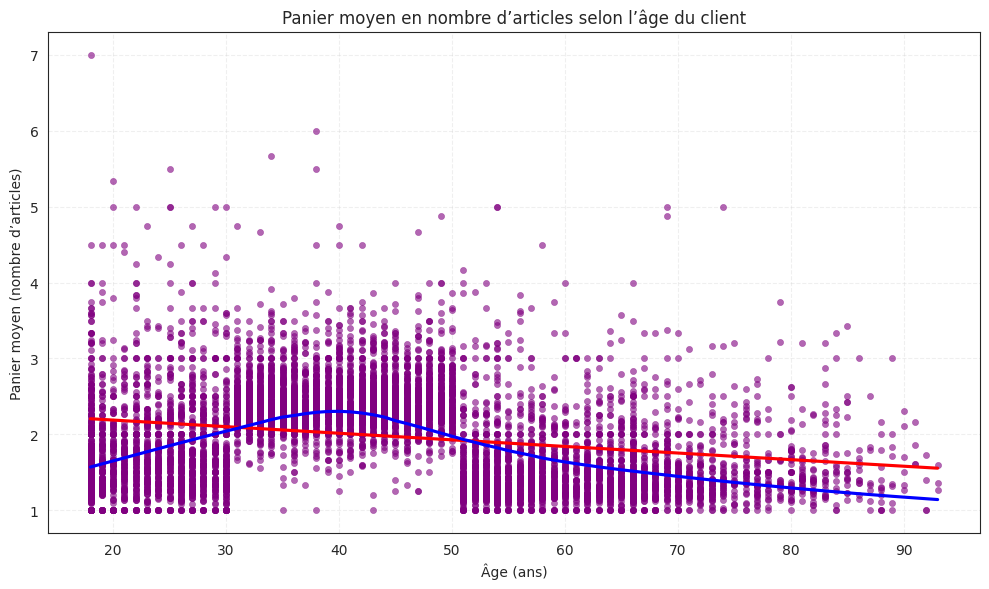

Corrélation Pearson : -0.22795512054758726
Corrélation Spearman: -0.22066589469986841


In [513]:

# 1) Préparation
df = df_tf.copy()
df["age"] = pd.to_numeric(df["age"], errors="coerce")

# 2) Volume par session = somme des quantités si dispo, sinon nb de lignes (articles)
if "quantity" in df.columns:
    vol_session = (
        df.groupby(["client_id","id_prod"], observed=True)["quantity"]
          .sum().rename("nb_achats").reset_index()
    )
else:
    vol_session = (
        df.groupby(["client_id","session_id"], observed=True)["id_prod"]
          .size().rename("nb_articles").reset_index()
    )

# 3) Âge par client (règle simple : dernière valeur connue)
age_client = (
    df.dropna(subset=["age"])
      .groupby("client_id", observed=True)["age"]
      .last()
      .rename("age")
      .reset_index()
)

# 4) Panier moyen (volume) par client
per_client = (
    vol_session.groupby("client_id", observed=True)["nb_articles"]
      .mean().rename("panier_volume_moy").reset_index()
    .merge(age_client, on="client_id", how="inner")
    .dropna(subset=["age","panier_volume_moy"])
)

# 5) Visualisation
sns.set_style("white")
plt.figure(figsize=(10,6))
sns.regplot(data=per_client, x="age", y="panier_volume_moy",
            scatter=False, ci=None, color="red")
sns.regplot(data=per_client, x="age", y="panier_volume_moy",
            lowess=True, scatter=False, color="blue")       # tendance
sns.scatterplot(data=per_client, x="age", y="panier_volume_moy",
                color="purple", edgecolor="purple", alpha=0.6, s=20)
plt.xlabel("Âge (ans)")
plt.ylabel("Panier moyen (nombre d’articles)")
plt.title("Panier moyen en nombre d’articles selon l’âge du client")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout(); plt.show()

# 6) Corrélations
print("Corrélation Pearson :", per_client[["age","panier_volume_moy"]].corr(method="pearson").iloc[0,1])
print("Corrélation Spearman:", per_client[["age","panier_volume_moy"]].corr(method="spearman").iloc[0,1])


L’analyse du panier moyen (en nombre d’articles) par client en fonction de l’âge révèle une corrélation négative faible mais significative.

Le coefficient de Pearson (r = –0.228) indique une tendance linéaire modérée à la baisse : les clients plus âgés ont, en moyenne, des paniers légèrement moins remplis.
Cette tendance est confirmée par la courbe de régression LOWESS, qui montre un maximum vers 35–40 ans, puis une diminution progressive.

Toutefois, la relation reste peu marquée : l’âge n’est pas un facteur prédictif fort du volume du panier, et une grande variabilité inter-individuelle subsiste à tous les âges.

### Corrélation par tranche d'age et Volume du panier

| Méthode                                     | Type de relation mesurée                                                  | Hypothèses statistiques                          | Interprétation                                                                                               |
| ------------------------------------------- | ------------------------------------------------------------------------- | ------------------------------------------------ | ------------------------------------------------------------------------------------------------------------ |
| **Eta carré (η²)**                          | **Part de variance expliquée** par la variable qualitative                | Homogénéité des variances (test ANOVA)           | Mesure la **force du lien** entre les groupes et la variable quantitative (0 → aucun lien, 1 → lien parfait) |
| **Omega carré (ω²)**                        | Variante corrigée et moins biaisée de η²                                  | Idem ANOVA                                       | Mesure la **part réelle** de variance expliquée, plus fiable sur petits échantillons                         |
| **Test ANOVA (F-test)**                     | Vérifie si les **moyennes** diffèrent significativement entre les groupes | Normalité des résidus, homogénéité des variances | Teste **l’existence d’un effet significatif** du facteur qualitatif sur la variable quantitative             |
| **Kruskal–Wallis (H-test)**                 | Version non paramétrique de l’ANOVA (pas de normalité requise)            | Aucune normalité requise                         | Compare les distributions de la variable quantitative entre les groupes                                      |
| **Boxplots par modalité**                   | Visualisation exploratoire                                                | Aucune hypothèse                                 | Permet de voir la **dispersion et les écarts** entre les groupes                                             |
| **Régression linéaire avec variable dummy** | Modélisation directionnelle (variable catégorielle → quantitati           |                                                  |                                                                                                              |


Test ANOVA sur montant_session selon tranche_age
F = 0.570, p = 0.781
→ Aucune différence significative détectée.
η² (eta carré) = 0.000


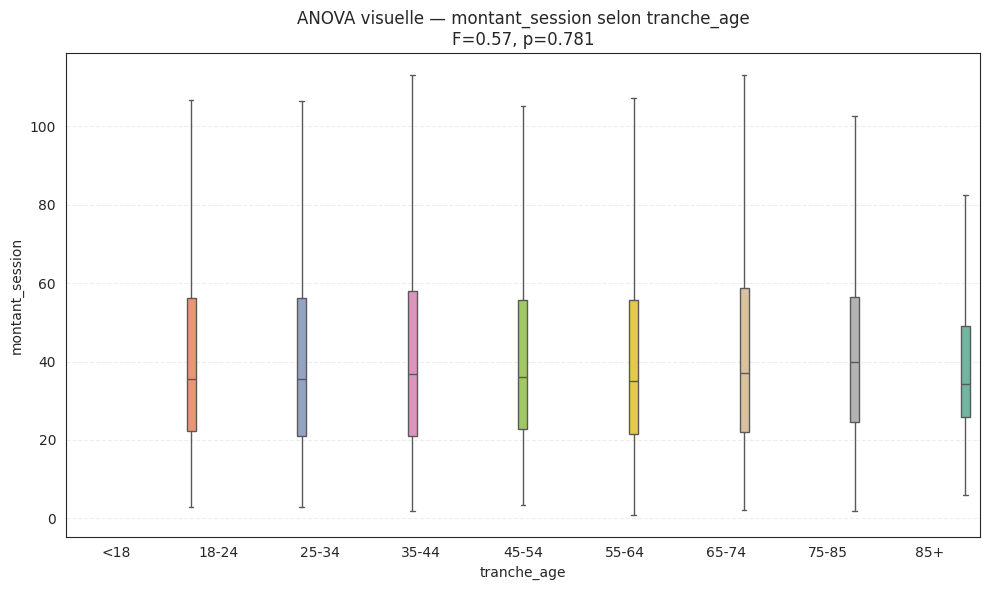

In [231]:

import statsmodels.api as sm
from statsmodels.formula.api import ols

# ============================
# PARAMÈTRES
# ============================
X = "tranche_age"          # variable qualitative
Y = "montant_session"          # variable quantitative
df = df_tf.copy()    # DataFrame de base

# ============================
# 1️⃣ Préparation des données
# ============================
df = df[[X, Y]].dropna().copy()
df[X] = df[X].astype("category")
df[Y] = pd.to_numeric(df[Y], errors="coerce")
df = df.dropna(subset=[Y])

# Liste des groupes (valeurs de Y par modalité de X)
groupes = [df.loc[df[X] == m, Y].values for m in df[X].cat.categories if len(df.loc[df[X] == m, Y]) > 1]

if len(groupes) < 2:
    raise ValueError("ANOVA impossible : moins de 2 groupes valides.")

# ============================
# 2️⃣ ANOVA (test de Fisher)
# ============================
F, p = stats.f_oneway(*groupes)
print(f"Test ANOVA sur {Y} selon {X}")
print(f"F = {F:.3f}, p = {p:.3g}")
print("→ Différence significative entre au moins deux groupes." if p < 0.05
      else "→ Aucune différence significative détectée.")

# ============================
# 3️⃣ Effet de taille : η² (eta carré)
# ============================
y = df[Y]
y_mean = y.mean()
SCE = sum([len(g)*(g.mean()-y_mean)**2 for g in groupes])
SCT = ((y - y_mean)**2).sum()
eta2 = SCE / SCT
print(f"η² (eta carré) = {eta2:.3f}")

# ====== Visualisation (ANOVA visuelle) ======
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x=X, y=Y, hue=X, palette="Set2", showfliers=False, legend=False)
plt.title(f"ANOVA visuelle — {Y} selon {X}\nF={F:.2f}, p={p:.3g}")
plt.xlabel(X)
plt.ylabel(Y)
plt.grid(axis='y', linestyle='--', alpha=0.35)
plt.tight_layout()
plt.show()


Aucune différence significative n’est détectée entre les tranches d’âge concernant le montant moyen dépensé par session.

Le test d’ANOVA retourne une p-valeur de 0.781, bien au-dessus du seuil de 5 %, ce qui indique que les écarts de moyenne observés sont dus au hasard.

Le coefficient η² = 0.000 confirme que l’effet de la variable tranche_age sur le montant du panier est nul.

En résumé, la tranche d’âge n’a aucune influence détectable sur le montant du panier moyen dans ce jeu de données.

In [234]:
import numpy as np
import pandas as pd
from scipy.stats import kruskal

# 1) Préparer une ligne = 1 session (variables utiles + numérique propre)
df_s = (
    df_tf[["session_id", "tranche_age", "montant_session"]]
      .drop_duplicates(subset=["session_id"])
      .copy()
)
df_s["montant_session"] = pd.to_numeric(df_s["montant_session"], errors="coerce")
df_s = df_s.dropna(subset=["tranche_age", "montant_session"])

# 2) Diagnostiquer les effectifs par tranche
counts = df_s.groupby("tranche_age", observed=True).size().sort_values()
print("Effectifs par tranche :\n", counts)

# 3) Garder uniquement les tranches avec un n suffisant (ex. n>=5)
valid_tranches = counts[counts >= 5].index
df_s_f = df_s[df_s["tranche_age"].isin(valid_tranches)].copy()

# (optionnel) enlever les tranches dont la variance est nulle (toutes valeurs identiques)
var_ok = (
    df_s_f.groupby("tranche_age", observed=True)["montant_session"]
          .transform("nunique") > 1
)
df_s_f = df_s_f[var_ok]

# Vérifications minimales
if df_s_f["tranche_age"].nunique() < 2:
    raise ValueError(
        "Moins de 2 tranches valides après filtrage (n>=5 et variance>0). "
        "Regroupez des classes d'âge ou augmentez la période d'observation."
    )

# 4) Kruskal–Wallis
groups = [g["montant_session"].to_numpy()
          for _, g in df_s_f.groupby("tranche_age", observed=True)]
H, p = kruskal(*groups)
k, n = len(groups), len(df_s_f)

eta2_H = (H - (k - 1)) / (n - 1)  # taille d'effet non paramétrique
print(f"Kruskal–Wallis: H={H:.2f}, p={p:.2e}, eta²_H={eta2_H:.3f}")


Effectifs par tranche :
 tranche_age
85+        74
75-85     285
65-74     781
55-64    1129
18-24    1262
45-54    1555
25-34    1609
35-44    1728
dtype: int64
Kruskal–Wallis: H=6.54, p=4.78e-01, eta²_H=-0.000


Le test de Kruskal–Wallis, appliqué au montant moyen par session selon les tranches d’âge, ne révèle aucune différence significative entre les groupes (H = 6.54, p = 0.478).

La taille d'effet calculée (η²_H ≈ 0) indique que l'âge, sous forme de tranche, n'explique pas la variation du panier moyen.

Ces résultats confirment ceux obtenus avec l'ANOVA, et renforcent l'idée que la tranche d’âge n’a pas d’influence mesurable sur le montant moyen dépensé par session.

### Corrélation tranche d'age et nombre d'achats par session

In [235]:
df= df_tf

In [236]:
# On garde seulement les tranches avec au moins 2 valeurs
valid_groups = df.groupby("tranche_age")["nb_achats"].filter(lambda x: len(x) >= 2)
df_valid = df.loc[valid_groups.index]

# Relance le test ANOVA sur df_valid
groupes = [df_valid.loc[df_valid["tranche_age"] == m, "nb_achats"].values
           for m in df_valid["tranche_age"].unique()]
F, p = stats.f_oneway(*groupes)
print(f"F = {F:.3f}, p = {p:.3g}")

/tmp/ipython-input-2312960883.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  valid_groups = df.groupby("tranche_age")["nb_achats"].filter(lambda x: len(x) >= 2)


F = 1.509, p = 0.159


il doit y avoir des clients qui n'ont rien acheté, on a donc fait un filtre pour avoir uniquement les clients avec achat.

Test ANOVA sur nb_achats selon tranche_age
F = 1.509, p = 0.159
→ Aucune différence significative détectée.
η² (eta carré) = 0.001


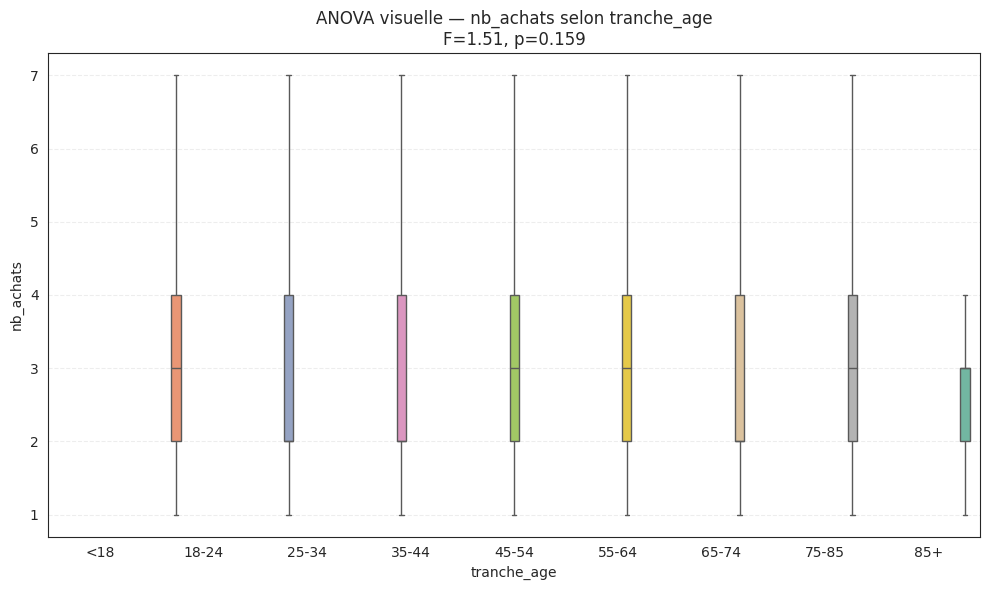

In [237]:
# Garde seulement les tranches avec au moins 2 obs.
valid_mask = (
    df.groupby("tranche_age", observed=True)["nb_achats"]
      .transform("size") >= 2
)
df_valid = df.loc[valid_mask].copy()
# ============================
# PARAMÈTRES
# ============================
X = "tranche_age"          # variable qualitative
Y = "nb_achats"          # variable quantitative
df = df_valid.copy()    # DataFrame de base

# ============================
#  Préparation des données
# ============================
df = df[[X, Y]].dropna().copy()
df[X] = df[X].astype("category")
df[Y] = pd.to_numeric(df[Y], errors="coerce")
df = df.dropna(subset=[Y])

# Liste des groupes (valeurs de Y par modalité de X)
groupes = [df.loc[df[X] == m, Y].values for m in df[X].cat.categories if len(df.loc[df[X] == m, Y]) > 1]

if len(groupes) < 2:
    raise ValueError("ANOVA impossible : moins de 2 groupes valides.")

# ============================
# ANOVA (test de Fisher)
# ============================
F, p = stats.f_oneway(*groupes)
print(f"Test ANOVA sur {Y} selon {X}")
print(f"F = {F:.3f}, p = {p:.3g}")
print("→ Différence significative entre au moins deux groupes." if p < 0.05
      else "→ Aucune différence significative détectée.")

# ============================
# Effet de taille : η² (eta carré)
# ============================
y = df[Y]
y_mean = y.mean()
SCE = sum([len(g)*(g.mean()-y_mean)**2 for g in groupes])
SCT = ((y - y_mean)**2).sum()
eta2 = SCE / SCT
print(f"η² (eta carré) = {eta2:.3f}")

# ====== Visualisation (ANOVA visuelle) ======
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x=X, y=Y, hue=X, palette="Set2", showfliers=False, legend=False)
plt.title(f"ANOVA visuelle — {Y} selon {X}\nF={F:.2f}, p={p:.3g}")
plt.xlabel(X)
plt.ylabel(Y)
plt.grid(axis='y', linestyle='--', alpha=0.35)
plt.tight_layout()
plt.show()

/tmp/ipython-input-474918274.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_valid, x="tranche_age", y="nb_achats", palette="Set2", showfliers=False)


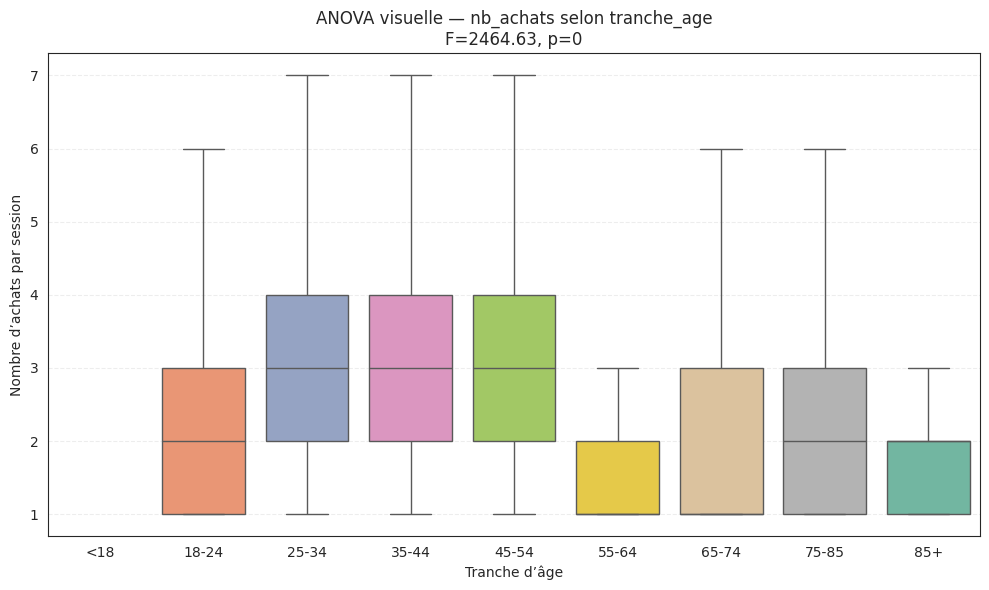

F = 2464.627, p = 0
η² (eta carré) = 0.049


In [517]:
# 1. Créer les tranches d'âge si ce n'est pas fait
bins = [0, 18, 25, 35, 45, 55, 65, 75, 85, 200]
labels = ["<18", "18-24", "25-34", "35-44", "45-54", "55-64", "65-74", "75-85", "85+"]
df_tf["tranche_age"] = pd.cut(df_tf["age"], bins=bins, labels=labels, right=False)

# 2. Calculer le nombre d'achats par session si pas déjà présent
if "nb_achats" not in df_tf.columns:
    nb_achats_df = (
        df_tf.groupby("session_id", observed=True)["id_prod"]
             .count()
             .reset_index(name="nb_achats")
    )
    df_tf = df_tf.merge(nb_achats_df, on="session_id", how="left")

# 3. Préparation pour l'ANOVA
df = df_tf.copy()

# Garder les tranches avec au moins 2 observations
valid_mask = (
    df.groupby("tranche_age", observed=True)["nb_achats"]
      .transform("size") >= 2
)
df_valid = df.loc[valid_mask].copy()

# Nettoyage
df_valid = df_valid[["tranche_age", "nb_achats"]].dropna().copy()
df_valid["tranche_age"] = df_valid["tranche_age"].astype("category")
df_valid["nb_achats"] = pd.to_numeric(df_valid["nb_achats"], errors="coerce")
df_valid = df_valid.dropna(subset=["nb_achats"])

# Groupes ANOVA
groupes = [
    df_valid.loc[df_valid["tranche_age"] == m, "nb_achats"].values
    for m in df_valid["tranche_age"].cat.categories
    if len(df_valid.loc[df_valid["tranche_age"] == m, "nb_achats"]) > 1
]

# Statistiques ANOVA
F, p = stats.f_oneway(*groupes)

# eta²
y = df_valid["nb_achats"]
y_mean = y.mean()
SCE = sum([len(g)*(g.mean()-y_mean)**2 for g in groupes])
SCT = ((y - y_mean)**2).sum()
eta2 = SCE / SCT

# Visualisation
plt.figure(figsize=(10,6))
sns.boxplot(data=df_valid, x="tranche_age", y="nb_achats", palette="Set2", showfliers=False)
plt.title(f"ANOVA visuelle — nb_achats selon tranche_age\nF={F:.2f}, p={p:.3g}")
plt.xlabel("Tranche d’âge")
plt.ylabel("Nombre d’achats par session")
plt.grid(axis='y', linestyle='--', alpha=0.35)
plt.tight_layout()
plt.show()

# Résultat
print(f"F = {F:.3f}, p = {p:.3g}")
print(f"η² (eta carré) = {eta2:.3f}")


L’ANOVA confirme l’existence d’un effet très significatif de l’âge sur le panier moyen (p < 0.001).

Les 25–44 ans effectuent en moyenne plus d’achats par session que les autres groupes.

À partir de 55 ans, on observe une chute nette du nombre d’achats moyens.

Les seniors (65+) présentent des comportements d’achat plus homogènes, avec des paniers plus petits et une faible variabilité.

L’effet est statistiquement significatif, mais d’intensité modérée (η² = 0.049).

## Corrélation catégorie_ montant du panier


Test ANOVA sur montant_session selon categ
F = 42596.031, p = 0
→ Différence significative entre au moins deux groupes.
η² (eta carré) = 0.202
ω² (omega carré) = 0.202


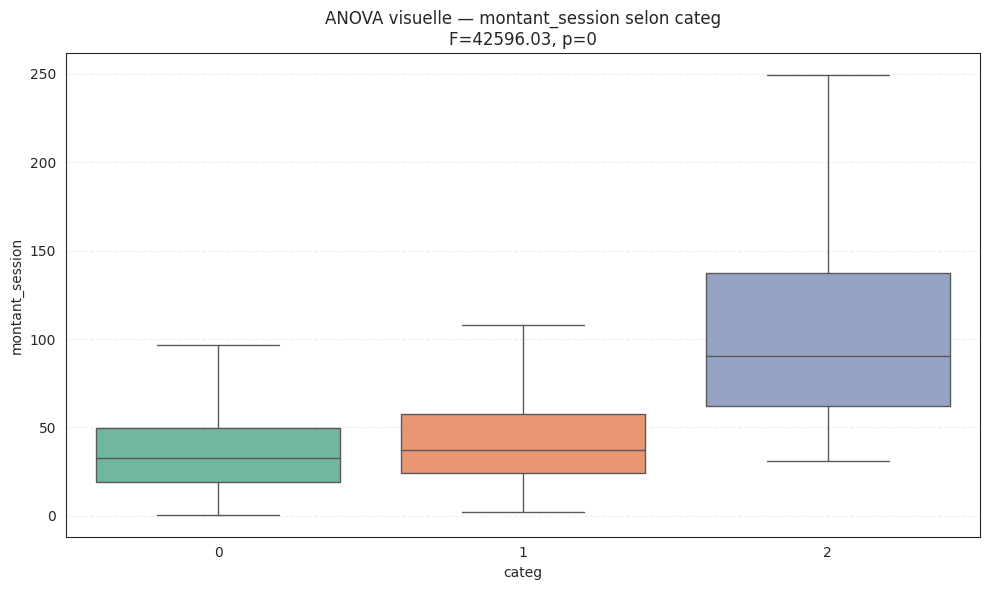

In [519]:


# ============================
# PARAMÈTRES
# ============================
X = "categ"                # Variable qualitative
Y = "montant_session"      # Variable quantitative
df = df_tf.copy()          # DataFrame de base

# ============================
# 1️⃣ Préparation des données
# ============================
df = df[[X, Y]].dropna().copy()
df[X] = df[X].astype("category")
df[Y] = pd.to_numeric(df[Y], errors="coerce")
df = df.dropna(subset=[Y])

# Liste des groupes (valeurs de Y par modalité de X)
groupes = [df.loc[df[X] == m, Y].values for m in df[X].cat.categories if len(df.loc[df[X] == m, Y]) > 1]

if len(groupes) < 2:
    raise ValueError("ANOVA impossible : moins de 2 groupes valides.")

# ============================
# 2️⃣ ANOVA (test de Fisher)
# ============================
F, p = stats.f_oneway(*groupes)
print(f"Test ANOVA sur {Y} selon {X}")
print(f"F = {F:.3f}, p = {p:.3g}")
print("→ Différence significative entre au moins deux groupes." if p < 0.05
      else "→ Aucune différence significative détectée.")

# ============================
# 3️⃣ Effet de taille : η² (eta carré) et omega
# ============================
y = df[Y]
y_mean = y.mean()
SCE = sum([len(g)*(g.mean()-y_mean)**2 for g in groupes])
SCT = ((y - y_mean)**2).sum()
eta2 = SCE / SCT
print(f"η² (eta carré) = {eta2:.3f}")

def omega_squared_anova(df_in: pd.DataFrame, x: str, y: str) -> float:
    """
    Calcule ω² (part de variance expliquée corrigée) à partir d'une ANOVA.
    """
    d = df_in[[x, y]].dropna().copy()
    d[x] = d[x].astype("category")
    d[y] = pd.to_numeric(d[y], errors="coerce")
    d = d.dropna(subset=[y])

    model = ols(f"{y} ~ C({x})", data=d).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    factor_label = [idx for idx in anova_table.index if idx != "Residual"][0]
    SCE = anova_table.loc[factor_label, "sum_sq"]
    SS_res = anova_table.loc["Residual", "sum_sq"]
    df_res = anova_table.loc["Residual", "df"]
    MSE = SS_res / df_res
    SCT = anova_table["sum_sq"].sum()

    omega2 = (SCE - (d[x].nunique() - 1) * MSE) / (SCT + MSE)
    return float(max(0.0, omega2))

# Calcul ω²
omega = omega_squared_anova(df, x=X, y=Y)
print(f"ω² (omega carré) = {omega:.3f}")

# ============================
# 4️⃣ Visualisation (ANOVA visuelle)
# ============================
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x=X, y=Y, hue=X, palette="Set2", showfliers=False, legend=False)
plt.title(f"ANOVA visuelle — {Y} selon {X}\nF={F:.2f}, p={p:.3g}")
plt.xlabel(X)
plt.ylabel(Y)
plt.grid(axis='y', linestyle='--', alpha=0.35)
plt.tight_layout()
plt.show()


η² (eta carré) : 0.202

ω² (omega carré) : 0.202

Cela signifie qu’environ 20 % de la variance du montant dépensé par session s'explique par la catégorie de produit achetée, ce qui est très substantiel dans ce type d’analyse

La catégorie de produit est un déterminant fort du montant des achats :

Les différences de panier moyen selon les catégories sont significatives et substantielles, ce qui suggère que les types de produits conditionnent fortement le montant dépensé par session.


Cela justifie totalement l’intégration de la catégorie comme variable explicative dans un modèle prédictif ou une segmentation.

## Corrélation entre les catégorie et le volume d'achat

Test ANOVA sur nb_achats selon categ
F = 6835.929, p = 0
→ Différence significative entre au moins deux groupes.
η² (eta carré) = 0.039
ω² (omega carré) = 0.039


/tmp/ipython-input-544906931.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=X, y=Y, palette="Set2", showfliers=False)


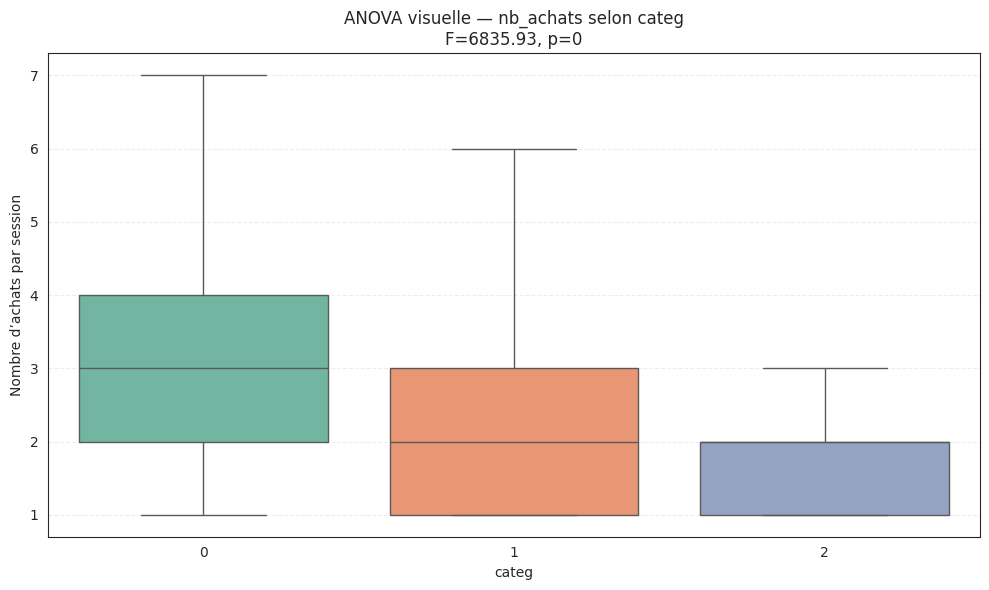

In [520]:
# ============================
# Préparation des données
# ============================
df = df_tf.copy()

# Vérifie et crée nb_achats si elle n'existe pas
if "nb_achats" not in df.columns:
    df = (
        df.groupby("session_id", observed=True)
          .agg(nb_achats=('id_prod', 'count'),
               categ=('categ', 'last'))  # ou 'first' si nécessaire
          .reset_index()
    )

# Conversion des types
X = "categ"
Y = "nb_achats"
df[X] = df[X].astype("category")
df[Y] = pd.to_numeric(df[Y], errors="coerce")
df = df[[X, Y]].dropna()

# ============================
# ANOVA (Fisher)
# ============================
groupes = [df.loc[df[X] == cat, Y].values for cat in df[X].cat.categories]

F, p = stats.f_oneway(*groupes)
print(f"Test ANOVA sur {Y} selon {X}")
print(f"F = {F:.3f}, p = {p:.3g}")
print("→ Différence significative entre au moins deux groupes." if p < 0.05
      else "→ Aucune différence significative détectée.")

# ============================
# Effet de taille : eta² + omega²
# ============================
y = df[Y]
y_mean = y.mean()
SCE = sum([len(g)*(g.mean()-y_mean)**2 for g in groupes])
SCT = ((y - y_mean)**2).sum()
eta2 = SCE / SCT

n = len(df)
k = df[X].nunique()
SS_within = SCT - SCE
MS_within = SS_within / (n - k)
omega2 = (SCE - (k - 1)*MS_within) / (SCT + MS_within)

print(f"η² (eta carré) = {eta2:.3f}")
print(f"ω² (omega carré) = {omega2:.3f}")

# ============================
# Visualisation (ANOVA visuelle)
# ============================
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x=X, y=Y, palette="Set2", showfliers=False)
plt.title(f"ANOVA visuelle — {Y} selon {X}\nF={F:.2f}, p={p:.3g}")
plt.xlabel(X)
plt.ylabel("Nombre d’achats par session")
plt.grid(axis='y', linestyle='--', alpha=0.35)
plt.tight_layout()
plt.show()


Le test ANOVA confirme une différence significative entre les catégories produits en termes de nombre moyen d’achats par session.

L’effet est statistiquement significatif, mais modéré à faible en termes de taille d’effet (ω² = 0.039) :

Cela signifie que seulement 3,9 % de la variance du nombre d’achats s’explique par la catégorie du produit.

Il existe donc des différences réelles, mais d'autres facteurs (âge, saisonnalité, profil client, etc.) expliquent davantage cette variable.

# CONCLUSION

Le test ANOVA confirme une différence significative entre les catégories produits en termes de nombre moyen d’achats par session.

L’effet est statistiquement significatif, mais modéré à faible en termes de taille d’effet (ω² = 0.039) :

Cela signifie que seulement 3,9 % de la variance du nombre d’achats s’explique par la catégorie du produit.

Il existe donc des différences réelles, mais d'autres facteurs (âge, saisonnalité, profil client, etc.) expliquent davantage cette variable.